## Startup

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm

import os
import pickle

In [45]:
random_state=42
np.random.seed(random_state)

In [46]:
from scripts.params import get_params

params = get_params()

## Data Retrieval

In [47]:
dataroute=os.path.join("..",  "data")
dumproute=os.path.join("..",  "dump")
resultsroute=os.path.join("..",  "results")

In [48]:
name=f'finaldf_train_{params["tablename"]}.pickle'
filename=os.path.join(dataroute, name)
with open(filename, 'rb') as handle:
    df=pickle.load(handle)


In [49]:
df.head()

^MERV_rets  ^MERV_log_rets  ^MERV_gk_vol  GGAL.BA_rets  \
2013-01-03    0.007552        0.007524      0.000129      0.010616   
2013-01-04    0.007092        0.007067      0.000158     -0.006303   
2013-01-07   -0.001035       -0.001035      0.000022      0.002114   
2013-01-08    0.008285        0.008251      0.000082     -0.008439   
2013-01-09    0.017826        0.017669      0.000273      0.000000   

            GGAL.BA_log_rets  GGAL.BA_gk_vol  GGAL_rets  GGAL_log_rets  \
2013-01-03          0.010560        0.000677  -0.012748      -0.012830   
2013-01-04         -0.006323        0.000208  -0.010043      -0.010094   
2013-01-07          0.002112        0.000063  -0.014493      -0.014599   
2013-01-08         -0.008475        0.000153  -0.016176      -0.016309   
2013-01-09          0.000000        0.000000   0.011958       0.011887   

            GGAL_gk_vol  YPFD.BA_rets  ...  BBAR.BA_gk_vol  BBAR_rets  \
2013-01-03     0.001228     -0.006862  ...        0.000169  -0.005725   
2013-01-04     0.000554      0.004936  ...        0.000406  -0.019194   
2013-01-07     0.000517      0.010805  ...        0.000492   0.015656   
2013-01-08     0.001085      0.049563  ...        0.000438  -0.015414   
2013-01-09     0.005238      0.000000  ...        0.000000  -0.003914   

            BBAR_log_rets  BBAR_gk_vol  USD_rets  USD_log_rets  USD_gk_vol  \
2013-01-03      -0.005742     0.000960  0.008830      0.008792    0.000014   
2013-01-04      -0.019381     0.000635  0.018043      0.017883    0.000133   
2013-01-07       0.015534     0.000511 -0.002489     -0.002492    0.000048   
2013-01-08      -0.015534     0.000642  0.015356      0.015239    0.000064   
2013-01-09      -0.003921     0.000147 -0.008671     -0.008709    0.001065   

            USD_^MERV_rets  USD_^MERV_log_rets  USD_^MERV_gk_vol  
2013-01-03        0.001247            0.001246          0.000129  
2013-01-04       -0.005727           -0.005744          0.000158  
2013-01-07       -0.009769           -0.009817          0.000022  
2013-01-08       -0.001117           -0.001118          0.000082  
2013-01-09        0.017245            0.017098          0.000273  

[5 rows x 39 columns]

In [50]:
tickerlist=params["tickerlist"]

## HMM Training

In [51]:
range_states=range(1,16)
emptydf=pd.DataFrame(columns=["AIC", "BIC"], index=range_states)
emptydf.fillna(np.inf, inplace=True)
results_dict_df={stock:emptydf for stock in tickerlist}

In [52]:
aic_best_model={stock:None for stock in tickerlist}
bic_best_model={stock:None for stock in tickerlist}

In [53]:
for stock in tickerlist:
    columns = [f'{stock}_log_rets', f'{stock}_gk_vol']
    insample_data = df[columns]

    param_dict={
        "covariance_type" : "diag", 
        "n_iter" : 500,
        "random_state" : random_state
        #no voy a usar startprob_prior por devlog 20-06-23
        }

    for nstate in range_states:
        model = hmm.GaussianHMM(n_components= nstate, **param_dict, verbose=False)
        results = model.fit(insample_data)

        convergence=results.monitor_.converged
        # esta es la condición de si el modelo convergió

        all_states_found=np.isclose(a=(model.transmat_.sum(axis=1)), b=1).all()
        # esta es la condición de que todos los estados (nstates) hayan sido observados
        # si no, alguna fila en la matriz de transición del modelo son 0.
        # el errormsg es "Some rows of transmat_ have zero sum because no transition from the state was ever observed".

        startprob_check = (model.startprob_.sum()==1)
        # esta es la condición de que los estados al inicializar estén definidos
        
        good_model = convergence and all_states_found and startprob_check

        if good_model:
            try:
                results_dict_df[stock].loc[nstate, "AIC"]=model.aic(insample_data)
                results_dict_df[stock].loc[nstate, "BIC"]=model.bic(insample_data)
            except ValueError:
                pass
        else: 
            print(">"*10,f"{stock} {nstate} did not converge")
            results_dict_df[stock].loc[nstate, "BIC"]=np.inf
            results_dict_df[stock].loc[nstate, "BIC"]=np.inf

Model is not converging.  Current: 18854.96287782649 is not greater than 18856.523959937764. Delta is -1.5610821112750273


^MERV 1
^MERV 2
^MERV 3


Model is not converging.  Current: 18922.516761095125 is not greater than 18922.640342060477. Delta is -0.1235809653517208
Model is not converging.  Current: 18926.94497080564 is not greater than 18929.056224078548. Delta is -2.111253272905742


^MERV 4
^MERV 5
^MERV 6
^MERV 7


Model is not converging.  Current: 17743.986469759584 is not greater than 17744.318424185913. Delta is -0.3319544263285934


^MERV 8
^MERV 9


Model is not converging.  Current: 18901.14175305869 is not greater than 18901.218720125846. Delta is -0.0769670671543281


^MERV 10
^MERV 11
^MERV 12


Model is not converging.  Current: 18894.30534189285 is not greater than 18898.387648824784. Delta is -4.082306931933999


^MERV 13


Model is not converging.  Current: 18175.347751458576 is not greater than 18175.393135498. Delta is -0.045384039425698575


^MERV 14
^MERV 15


Model is not converging.  Current: 18874.643494133776 is not greater than 18875.217711266127. Delta is -0.5742171323508956


GGAL.BA 1
GGAL.BA 2
GGAL.BA 3


Model is not converging.  Current: 17772.508495229125 is not greater than 17774.739898868018. Delta is -2.231403638892516


GGAL.BA 4
>>>>>>>>>> GGAL.BA 4 did not converge
GGAL.BA 5


Model is not converging.  Current: 17172.447671294663 is not greater than 17172.459599326055. Delta is -0.011928031392017147


>>>>>>>>>> GGAL.BA 5 did not converge
GGAL.BA 6


Model is not converging.  Current: 17745.623381609512 is not greater than 17748.327545529115. Delta is -2.704163919603161


GGAL.BA 7


Model is not converging.  Current: 16770.464039001996 is not greater than 16770.89286297307. Delta is -0.4288239710731432


GGAL.BA 8


Model is not converging.  Current: 17730.057777085287 is not greater than 17733.110235595243. Delta is -3.0524585099556134


GGAL.BA 9
GGAL.BA 10


Model is not converging.  Current: 17727.871897288493 is not greater than 17727.90753497917. Delta is -0.03563769067841349


GGAL.BA 11
GGAL.BA 12


Model is not converging.  Current: 17719.10729938319 is not greater than 17721.086789298868. Delta is -1.9794899156768224


GGAL.BA 13
GGAL.BA 14


Model is not converging.  Current: 17715.00048441379 is not greater than 17722.6226053033. Delta is -7.6221208895076416


GGAL.BA 15


Model is not converging.  Current: 17743.2126473846 is not greater than 17748.248667839187. Delta is -5.036020454586833
Model is not converging.  Current: 17376.14890197371 is not greater than 17376.156667453055. Delta is -0.007765479345835047


>>>>>>>>>> GGAL.BA 15 did not converge
GGAL 1
GGAL 2
GGAL 3


Model is not converging.  Current: 17421.648537743917 is not greater than 17422.059638359035. Delta is -0.41110061511790263


GGAL 4
GGAL 5


Model is not converging.  Current: 16872.266520872403 is not greater than 16872.632488444295. Delta is -0.36596757189181517
Model is not converging.  Current: 16853.893297614984 is not greater than 16857.796606510943. Delta is -3.9033088959586166


GGAL 6
>>>>>>>>>> GGAL 6 did not converge
GGAL 7


Model is not converging.  Current: 17405.414747463186 is not greater than 17413.864602481484. Delta is -8.449855018297967


GGAL 8


c:\Users\Alfred\.julia\conda\3\envs\hmm\Lib\site-packages\hmmlearn\hmm.py:340: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from 

>>>>>>>>>> GGAL 8 did not converge
GGAL 9
GGAL 10


Model is not converging.  Current: 17388.544828150683 is not greater than 17388.564328106422. Delta is -0.019499955738865538


GGAL 11


Model is not converging.  Current: 17367.72792632112 is not greater than 17367.950352545504. Delta is -0.22242622438352555


GGAL 12


Model is not converging.  Current: 17391.57804246445 is not greater than 17396.937080558986. Delta is -5.359038094535208


GGAL 13


Model is not converging.  Current: 16837.31692201468 is not greater than 16837.956881080612. Delta is -0.6399590659311798


GGAL 14


Model is not converging.  Current: 17420.90501007856 is not greater than 17421.091638665333. Delta is -0.18662858677271288


GGAL 15


Model is not converging.  Current: 17326.582288136113 is not greater than 17344.597220789186. Delta is -18.01493265307363
Model is not converging.  Current: 17800.626999331365 is not greater than 17802.65917155106. Delta is -2.032172219693166
Model is not converging.  Current: 17222.53180016463 is not greater than 17223.314913798473. Delta is -0.7831136338427314


YPFD.BA 1
YPFD.BA 2
YPFD.BA 3
YPFD.BA 4


Model is not converging.  Current: 17834.528138037287 is not greater than 17834.557422812744. Delta is -0.02928477545719943


YPFD.BA 5


c:\Users\Alfred\.julia\conda\3\envs\hmm\Lib\site-packages\hmmlearn\hmm.py:340: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from 

>>>>>>>>>> YPFD.BA 5 did not converge
YPFD.BA 6
YPFD.BA 7


Model is not converging.  Current: 17220.366214344893 is not greater than 17222.302417235725. Delta is -1.9362028908326465


YPFD.BA 8


Model is not converging.  Current: 17798.792427558692 is not greater than 17798.898789656123. Delta is -0.10636209743097425


>>>>>>>>>> YPFD.BA 8 did not converge
YPFD.BA 9


Model is not converging.  Current: 17826.38732486051 is not greater than 17827.423965834478. Delta is -1.0366409739690425


YPFD.BA 10


Model is not converging.  Current: 17225.251571233086 is not greater than 17225.3600731166. Delta is -0.10850188351469114


YPFD.BA 11
YPFD.BA 12


Model is not converging.  Current: 17232.19631488265 is not greater than 17232.20381060694. Delta is -0.007495724290492944


YPFD.BA 13


Model is not converging.  Current: 17778.291796360863 is not greater than 17785.31079929863. Delta is -7.019002937766345


YPFD.BA 14


Model is not converging.  Current: 17247.41636176166 is not greater than 17248.34424989968. Delta is -0.9278881380196253


>>>>>>>>>> YPFD.BA 14 did not converge
YPFD.BA 15


Model is not converging.  Current: 17194.22342857503 is not greater than 17194.767693578106. Delta is -0.5442650030745426
Model is not converging.  Current: 17646.064794280628 is not greater than 17648.9842399738. Delta is -2.9194456931727473
Model is not converging.  Current: 17102.09427315503 is not greater than 17102.472666230442. Delta is -0.3783930754107132


YPF 1
YPF 2
YPF 3
>>>>>>>>>> YPF 3 did not converge
YPF 4


Model is not converging.  Current: 17703.88789990591 is not greater than 17707.791707227057. Delta is -3.9038073211486335
Model is not converging.  Current: 17133.72848875819 is not greater than 17134.345010003926. Delta is -0.6165212457344751


YPF 5
>>>>>>>>>> YPF 5 did not converge
YPF 6


Model is not converging.  Current: 17707.840571269346 is not greater than 17709.202135573487. Delta is -1.3615643041412113


YPF 7


Model is not converging.  Current: 17156.87808752897 is not greater than 17156.975011501658. Delta is -0.09692397268736386


YPF 8
YPF 9


Model is not converging.  Current: 17707.400110072256 is not greater than 17711.465377348137. Delta is -4.065267275880615


YPF 10


Model is not converging.  Current: 17134.12913570313 is not greater than 17136.187455328167. Delta is -2.0583196250372566


YPF 11


Model is not converging.  Current: 17754.727164271506 is not greater than 17759.977595586603. Delta is -5.250431315096648


>>>>>>>>>> YPF 11 did not converge
YPF 12


Model is not converging.  Current: 17705.249370527603 is not greater than 17715.793864074527. Delta is -10.544493546924059


YPF 13


Model is not converging.  Current: 17112.507487297702 is not greater than 17114.352903128874. Delta is -1.8454158311724314


YPF 14
YPF 15


Model is not converging.  Current: 17664.678419971824 is not greater than 17681.928657295426. Delta is -17.25023732360205


EDN.BA 1
EDN.BA 2
EDN.BA 3


Model is not converging.  Current: 17159.36524722281 is not greater than 17160.897804423945. Delta is -1.532557201135205


EDN.BA 4
EDN.BA 5


Model is not converging.  Current: 16623.0734432425 is not greater than 16623.101595552616. Delta is -0.028152310114819556


EDN.BA 6


Model is not converging.  Current: 16581.72170426638 is not greater than 16583.54739207498. Delta is -1.8256878085994686


EDN.BA 7
>>>>>>>>>> EDN.BA 7 did not converge
EDN.BA 8
EDN.BA 9


Model is not converging.  Current: 17063.76033184445 is not greater than 17076.279813233814. Delta is -12.519481389364955


EDN.BA 10
EDN.BA 11
EDN.BA 12


Model is not converging.  Current: 17155.988347823597 is not greater than 17155.994811153894. Delta is -0.006463330297265202


EDN.BA 13


c:\Users\Alfred\.julia\conda\3\envs\hmm\Lib\site-packages\hmmlearn\hmm.py:340: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from 

>>>>>>>>>> EDN.BA 13 did not converge
EDN.BA 14


Model is not converging.  Current: 17098.237846440476 is not greater than 17100.22684466866. Delta is -1.9889982281856646


EDN.BA 15


Model is not converging.  Current: 17158.635353050176 is not greater than 17158.646099098885. Delta is -0.010746048708824674


EDN 1
EDN 2
EDN 3


Model is not converging.  Current: 16565.70547807716 is not greater than 16567.10991095012. Delta is -1.404432872957841
Model is not converging.  Current: 16569.625033690416 is not greater than 16571.550107720777. Delta is -1.9250740303614293


EDN 4
EDN 5


Model is not converging.  Current: 16520.248571932916 is not greater than 16524.931708139102. Delta is -4.683136206185736


EDN 6
EDN 7


Model is not converging.  Current: 15787.368555240088 is not greater than 15789.178888695958. Delta is -1.810333455870932


>>>>>>>>>> EDN 7 did not converge
EDN 8
EDN 9


Model is not converging.  Current: 16475.781493253446 is not greater than 16483.654861526913. Delta is -7.873368273467349


>>>>>>>>>> EDN 9 did not converge
EDN 10


c:\Users\Alfred\.julia\conda\3\envs\hmm\Lib\site-packages\hmmlearn\hmm.py:340: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from 

>>>>>>>>>> EDN 10 did not converge
EDN 11


Model is not converging.  Current: 16596.871287470174 is not greater than 16598.674730159568. Delta is -1.8034426893937052


EDN 12


Model is not converging.  Current: 16068.881712363116 is not greater than 16069.879407156544. Delta is -0.9976947934283089


>>>>>>>>>> EDN 12 did not converge
EDN 13


c:\Users\Alfred\.julia\conda\3\envs\hmm\Lib\site-packages\hmmlearn\hmm.py:340: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from 

>>>>>>>>>> EDN 13 did not converge
EDN 14


Model is not converging.  Current: 16067.043867908968 is not greater than 16069.715123714326. Delta is -2.671255805358669


>>>>>>>>>> EDN 14 did not converge
EDN 15


Model is not converging.  Current: 16034.289272699747 is not greater than 16037.556705204854. Delta is -3.267432505106626
Model is not converging.  Current: 16823.532553851022 is not greater than 16825.761326282656. Delta is -2.2287724316338426


BMA.BA 1
BMA.BA 2
BMA.BA 3
>>>>>>>>>> BMA.BA 3 did not converge
BMA.BA 4


Model is not converging.  Current: 17418.733560641478 is not greater than 17420.146983289796. Delta is -1.4134226483183738


>>>>>>>>>> BMA.BA 4 did not converge
BMA.BA 5


Model is not converging.  Current: 16870.490577848275 is not greater than 16871.021808294045. Delta is -0.5312304457693244
Model is not converging.  Current: 17394.0246122937 is not greater than 17397.841352129268. Delta is -3.816739835569024


>>>>>>>>>> BMA.BA 5 did not converge
BMA.BA 6
>>>>>>>>>> BMA.BA 6 did not converge
BMA.BA 7


Model is not converging.  Current: 16514.09586784607 is not greater than 16515.960707224065. Delta is -1.8648393779949402


>>>>>>>>>> BMA.BA 7 did not converge
BMA.BA 8


Model is not converging.  Current: 17374.683435988984 is not greater than 17381.213305890386. Delta is -6.52986990140198


BMA.BA 9
BMA.BA 10


Model is not converging.  Current: 17355.978991838947 is not greater than 17366.169121767194. Delta is -10.190129928247188
Model is not converging.  Current: 17353.85341303484 is not greater than 17357.90432299242. Delta is -4.050909957579279


BMA.BA 11
BMA.BA 12


Model is not converging.  Current: 17353.61901996006 is not greater than 17355.933400649235. Delta is -2.314380689174868


BMA.BA 13


Model is not converging.  Current: 17371.7855818116 is not greater than 17371.788015725477. Delta is -0.0024339138763025403


BMA.BA 14


Model is not converging.  Current: 17405.81877120986 is not greater than 17409.82421478083. Delta is -4.005443570971693


BMA.BA 15


Model is not converging.  Current: 17424.85703728817 is not greater than 17425.983127170406. Delta is -1.1260898822365562
Model is not converging.  Current: 17301.75240439675 is not greater than 17302.788697502016. Delta is -1.0362931052659405


>>>>>>>>>> BMA.BA 15 did not converge
BMA 1
BMA 2
BMA 3


Model is not converging.  Current: 17356.143949244073 is not greater than 17360.249976993433. Delta is -4.106027749359782
Model is not converging.  Current: 17367.27237836682 is not greater than 17370.267271844044. Delta is -2.9948934772255598
Model is not converging.  Current: 16856.872252654364 is not greater than 16858.439556935326. Delta is -1.5673042809612525


>>>>>>>>>> BMA 3 did not converge
BMA 4
>>>>>>>>>> BMA 4 did not converge
BMA 5
BMA 6


Model is not converging.  Current: 17353.12159806404 is not greater than 17360.44857800053. Delta is -7.326979936489806
Model is not converging.  Current: 16501.855037772155 is not greater than 16505.839322695636. Delta is -3.9842849234810274


BMA 7
BMA 8
BMA 9


Model is not converging.  Current: 16859.51025814898 is not greater than 16860.00491224166. Delta is -0.4946540926794114
Model is not converging.  Current: 17293.42392956125 is not greater than 17298.170359717686. Delta is -4.746430156435963


>>>>>>>>>> BMA 9 did not converge
BMA 10
BMA 11


Model is not converging.  Current: 17344.44471833077 is not greater than 17346.48135308921. Delta is -2.036634758438595


BMA 12
BMA 13


Model is not converging.  Current: 16842.12768042595 is not greater than 16842.14638624375. Delta is -0.01870581779803615


BMA 14


Model is not converging.  Current: 17361.432233023286 is not greater than 17366.62144064272. Delta is -5.189207619434455


BMA 15


Model is not converging.  Current: 17285.703949497485 is not greater than 17296.002770697734. Delta is -10.298821200249222


BBAR.BA 1
BBAR.BA 2
BBAR.BA 3
BBAR.BA 4
BBAR.BA 5


c:\Users\Alfred\.julia\conda\3\envs\hmm\Lib\site-packages\hmmlearn\hmm.py:340: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


>>>>>>>>>> BBAR.BA 5 did not converge
BBAR.BA 6
BBAR.BA 7


Model is not converging.  Current: 19461.19834975107 is not greater than 19461.93646099718. Delta is -0.7381112461116572


BBAR.BA 8
BBAR.BA 9
BBAR.BA 10
BBAR.BA 11
BBAR.BA 12


c:\Users\Alfred\.julia\conda\3\envs\hmm\Lib\site-packages\hmmlearn\hmm.py:340: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from 

>>>>>>>>>> BBAR.BA 12 did not converge
BBAR.BA 13


Model is not converging.  Current: 18672.725562842665 is not greater than 18676.831782359. Delta is -4.106219516335841


>>>>>>>>>> BBAR.BA 13 did not converge
BBAR.BA 14


Model is not converging.  Current: 18839.95973693278 is not greater than 18840.185383727283. Delta is -0.22564679450442782


>>>>>>>>>> BBAR.BA 14 did not converge
BBAR.BA 15


Model is not converging.  Current: 16980.476473934974 is not greater than 16980.912518619232. Delta is -0.43604468425837695


BBAR 1
BBAR 2
BBAR 3


Model is not converging.  Current: 17167.56075972157 is not greater than 17172.206482001682. Delta is -4.645722280110931
Model is not converging.  Current: 17129.520644004242 is not greater than 17131.30485517575. Delta is -1.784211171507195


BBAR 4
BBAR 5


Model is not converging.  Current: 16637.284874041692 is not greater than 16637.642297514678. Delta is -0.357423472985829
Model is not converging.  Current: 17113.632859487705 is not greater than 17117.269557795255. Delta is -3.6366983075495227


BBAR 6
BBAR 7


Model is not converging.  Current: 16303.098582975319 is not greater than 16304.41334226665. Delta is -1.3147592913301196


>>>>>>>>>> BBAR 7 did not converge
BBAR 8


Model is not converging.  Current: 17147.914692446288 is not greater than 17147.927722420645. Delta is -0.013029974357777974


BBAR 9


Model is not converging.  Current: 17099.16613764689 is not greater than 17108.19829801209. Delta is -9.032160365197342


BBAR 10


c:\Users\Alfred\.julia\conda\3\envs\hmm\Lib\site-packages\hmmlearn\hmm.py:340: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: -inf is not greater than 16662.588072934486. Delta is -inf


>>>>>>>>>> BBAR 10 did not converge
BBAR 11


Model is not converging.  Current: 17145.555832378184 is not greater than 17145.668710925078. Delta is -0.11287854689362575


BBAR 12


Model is not converging.  Current: 16659.67892785111 is not greater than 16662.438627895473. Delta is -2.7597000443638535


BBAR 13


Model is not converging.  Current: 16596.707083162644 is not greater than 16598.904545823316. Delta is -2.19746266067159


>>>>>>>>>> BBAR 13 did not converge
BBAR 14


Model is not converging.  Current: 17104.796963684155 is not greater than 17105.618710827897. Delta is -0.821747143741959


BBAR 15


Model is not converging.  Current: 17121.98634655059 is not greater than 17128.800132705786. Delta is -6.813786155194975


In [54]:
for stock in tickerlist:
    columns = [f'{stock}_log_rets', f'{stock}_gk_vol']
    insample_data = df[columns]
    
    best_aic_nstate=results_dict_df[stock]["AIC"].astype(float).idxmin()
    best_bic_nstate=results_dict_df[stock]["BIC"].astype(float).idxmin()
    print(f"For stock {stock}, best AIC: {best_aic_nstate} best BIC: {best_bic_nstate}")

    aic_best_model[stock]=hmm.GaussianHMM(n_components = best_aic_nstate, **param_dict).fit(insample_data)
    bic_best_model[stock]=hmm.GaussianHMM(n_components = best_bic_nstate, **param_dict).fit(insample_data)

For stock ^MERV, best AIC: 7 best BIC: 3


Model is not converging.  Current: 17743.986469759584 is not greater than 17744.318424185913. Delta is -0.3319544263285934
Model is not converging.  Current: 18922.516761095125 is not greater than 18922.640342060477. Delta is -0.1235809653517208
Model is not converging.  Current: 16770.464039001974 is not greater than 16770.892862973047. Delta is -0.4288239710731432


For stock GGAL.BA, best AIC: 7 best BIC: 3
For stock GGAL, best AIC: 7 best BIC: 3


Model is not converging.  Current: 17405.414747463186 is not greater than 17413.864602481484. Delta is -8.449855018297967
Model is not converging.  Current: 17220.366214344893 is not greater than 17222.302417235725. Delta is -1.9362028908326465


For stock YPFD.BA, best AIC: 7 best BIC: 3


Model is not converging.  Current: 17222.531800164437 is not greater than 17223.31491379854. Delta is -0.7831136341010279


For stock YPF, best AIC: 7 best BIC: 3


Model is not converging.  Current: 17156.87808752897 is not greater than 17156.975011501658. Delta is -0.09692397268736386
Model is not converging.  Current: 17102.09427315503 is not greater than 17102.472666230442. Delta is -0.3783930754107132
Model is not converging.  Current: 16581.72170426582 is not greater than 16583.54739207417. Delta is -1.825687808352086


For stock EDN.BA, best AIC: 7 best BIC: 3


Model is not converging.  Current: 17159.36524722281 is not greater than 17160.897804423945. Delta is -1.532557201135205
Model is not converging.  Current: 15787.36855523936 is not greater than 15789.178888695578. Delta is -1.810333456218359


For stock EDN, best AIC: 7 best BIC: 3


Model is not converging.  Current: 16565.70547807547 is not greater than 16567.109910946674. Delta is -1.4044328712043352
Model is not converging.  Current: 16514.09586784607 is not greater than 16515.960707224065. Delta is -1.8648393779949402
Model is not converging.  Current: 16823.532553851048 is not greater than 16825.76132628264. Delta is -2.228772431593825


For stock BMA.BA, best AIC: 7 best BIC: 3


Model is not converging.  Current: 16501.855037773297 is not greater than 16505.83932269615. Delta is -3.984284922851657


For stock BMA, best AIC: 7 best BIC: 3


Model is not converging.  Current: 17356.143949253845 is not greater than 17360.249976997107. Delta is -4.10602774326253


For stock BBAR.BA, best AIC: 7 best BIC: 3


Model is not converging.  Current: 19461.19834975107 is not greater than 19461.93646099718. Delta is -0.7381112461116572
Model is not converging.  Current: 16303.098582975319 is not greater than 16304.41334226665. Delta is -1.3147592913301196


For stock BBAR, best AIC: 7 best BIC: 3


Model is not converging.  Current: 17167.56075972157 is not greater than 17172.206482001682. Delta is -4.645722280110931


# Generating out of sample data

In [55]:
name=f'finaldf_test_{params["tablename"]}.pickle'
filename=os.path.join(dataroute, name)
with open(filename, 'rb') as handle:
    df_test=pickle.load(handle)

In [56]:
def generate_samples_residuals(model, insample_data, oos_data):
    """
    
    """
    # como el modelo es memoryless, sólo necesito 1 día de observación para saber en qué estado estoy
    # por lo tanto, en vez de complicarme con dos datasets, puedo agregarle el ultimo día de insample_data al ppio de oos_data
    # pseudocodigo
    oos_data=pd.concat([insample_data[-1:], oos_data])
    del insample_data

    samples=pd.DataFrame(columns=oos_data.columns)
    residuals=pd.DataFrame(columns=oos_data.columns)

    # for i=0
    for i in range(1,
                   len(oos_data.index)):
        prev_obs=oos_data[i-1:i]

        todays_obs = oos_data[i:i+1]
        todays_date = todays_obs.index

        state=model.decode(prev_obs)[1][-1]
        # decode()[0] is the log probability, decode()[1] is the sequence of states, [-1] is the last state
        # since we have added the last datum of insample_data to oos_data, then the 
            # TODO: revisar que tenga sentido decodear solo el ultimo día.
            # La alternativa es agregar diez días de insample al principio y usar un decode con diez dias, 
            # me quedo con el ultimo valor del array que maximiza la log-likelihood de la secuencia entera
            # pero como es memoryless, not sure if it makesense
        
        sample = model.sample(n_samples=1, random_state=random_state, currstate=state)[0]
        # sample()[0] is the array with observations of the sampled variables, sample()[1] is the value of the currstate
        sample = pd.DataFrame(data=sample, columns=oos_data.columns, index=todays_date)

        samples=pd.concat([samples, sample])   
        # sampling given state t-1
        # observar realización en t+i
        residual = todays_obs-sample
        
        residuals=pd.concat([residuals, residual])
    
    return samples, residuals

In [57]:
aic_best_residuals={stock:None for stock in tickerlist}
bic_best_residuals={stock:None for stock in tickerlist}

In [60]:
for stock in tickerlist:
    columns = [f'{stock}_log_rets', f'{stock}_gk_vol']
    insample_data = df[columns]
    oos_data=df_test[columns]

    samples, aic_best_residuals[stock] = generate_samples_residuals(
        aic_best_model[stock], 
        insample_data=insample_data, 
        oos_data=oos_data)

    samples, bic_best_residuals[stock] = generate_samples_residuals(
        bic_best_model[stock], 
        insample_data=insample_data, 
        oos_data=oos_data)

# Guardado de datos

In [62]:
with open(os.path.join(resultsroute, f"""HMM_univ_{params["tablename"]}_aic_bestmodels.pickle"""), "wb") as output_file:
    pickle.dump(aic_best_model, output_file)

with open(os.path.join(resultsroute, f"""HMM_univ_{params["tablename"]}_bic_bestmodels.pickle"""), "wb") as output_file:
    pickle.dump(bic_best_model, output_file)

In [63]:
with open(os.path.join(resultsroute, f"""HMM_univ_{params["tablename"]}_aic_residuals.pickle"""), "wb") as output_file:
    pickle.dump(aic_best_residuals, output_file)

with open(os.path.join(resultsroute, f"""HMM_univ_{params["tablename"]}_bic_residuals.pickle"""), "wb") as output_file:
    pickle.dump(bic_best_residuals, output_file)

# Graficando

In [72]:
def plot_close_rets_vol(model, data, key, IC):
    prediction= model.predict(data)
    states=set(prediction)

    fig=plt.figure(figsize = (20, 20))
    plt.tight_layout()
    plt.title(f"{key} Log returns and intraday Vol\n{model.n_components} states / best by {IC}")

    for subplot, var in zip(range(1,3), data.columns):    
        plt.subplot(2,1,subplot)
        for i in set(prediction):
            state = (prediction == i)
            x = data.index[state]
            y = data[var].iloc[state]
            plt.plot(x, y, '.')
        plt.legend(states, fontsize=16)
        
        plt.grid(True)
        plt.xlabel("datetime", fontsize=16)
        plt.ylabel(var, fontsize=16)
            
    plt.savefig(os.path.join(resultsroute, "graphs", 
                             f"HMM", 
                             f"{key}_model_{IC}.png"))

C:\Users\Alfred\AppData\Local\Temp\ipykernel_19012\3068106688.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,1,subplot)
C:\Users\Alfred\AppData\Local\Temp\ipykernel_19012\3068106688.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,1,subplot)
C:\Users\Alfred\AppData\Local\Temp\ipykernel_19012\3068106688.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,1,subplot)
C:\Users\Alfred\AppData\Local\Temp\ipykernel_19012\3068106688.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases l

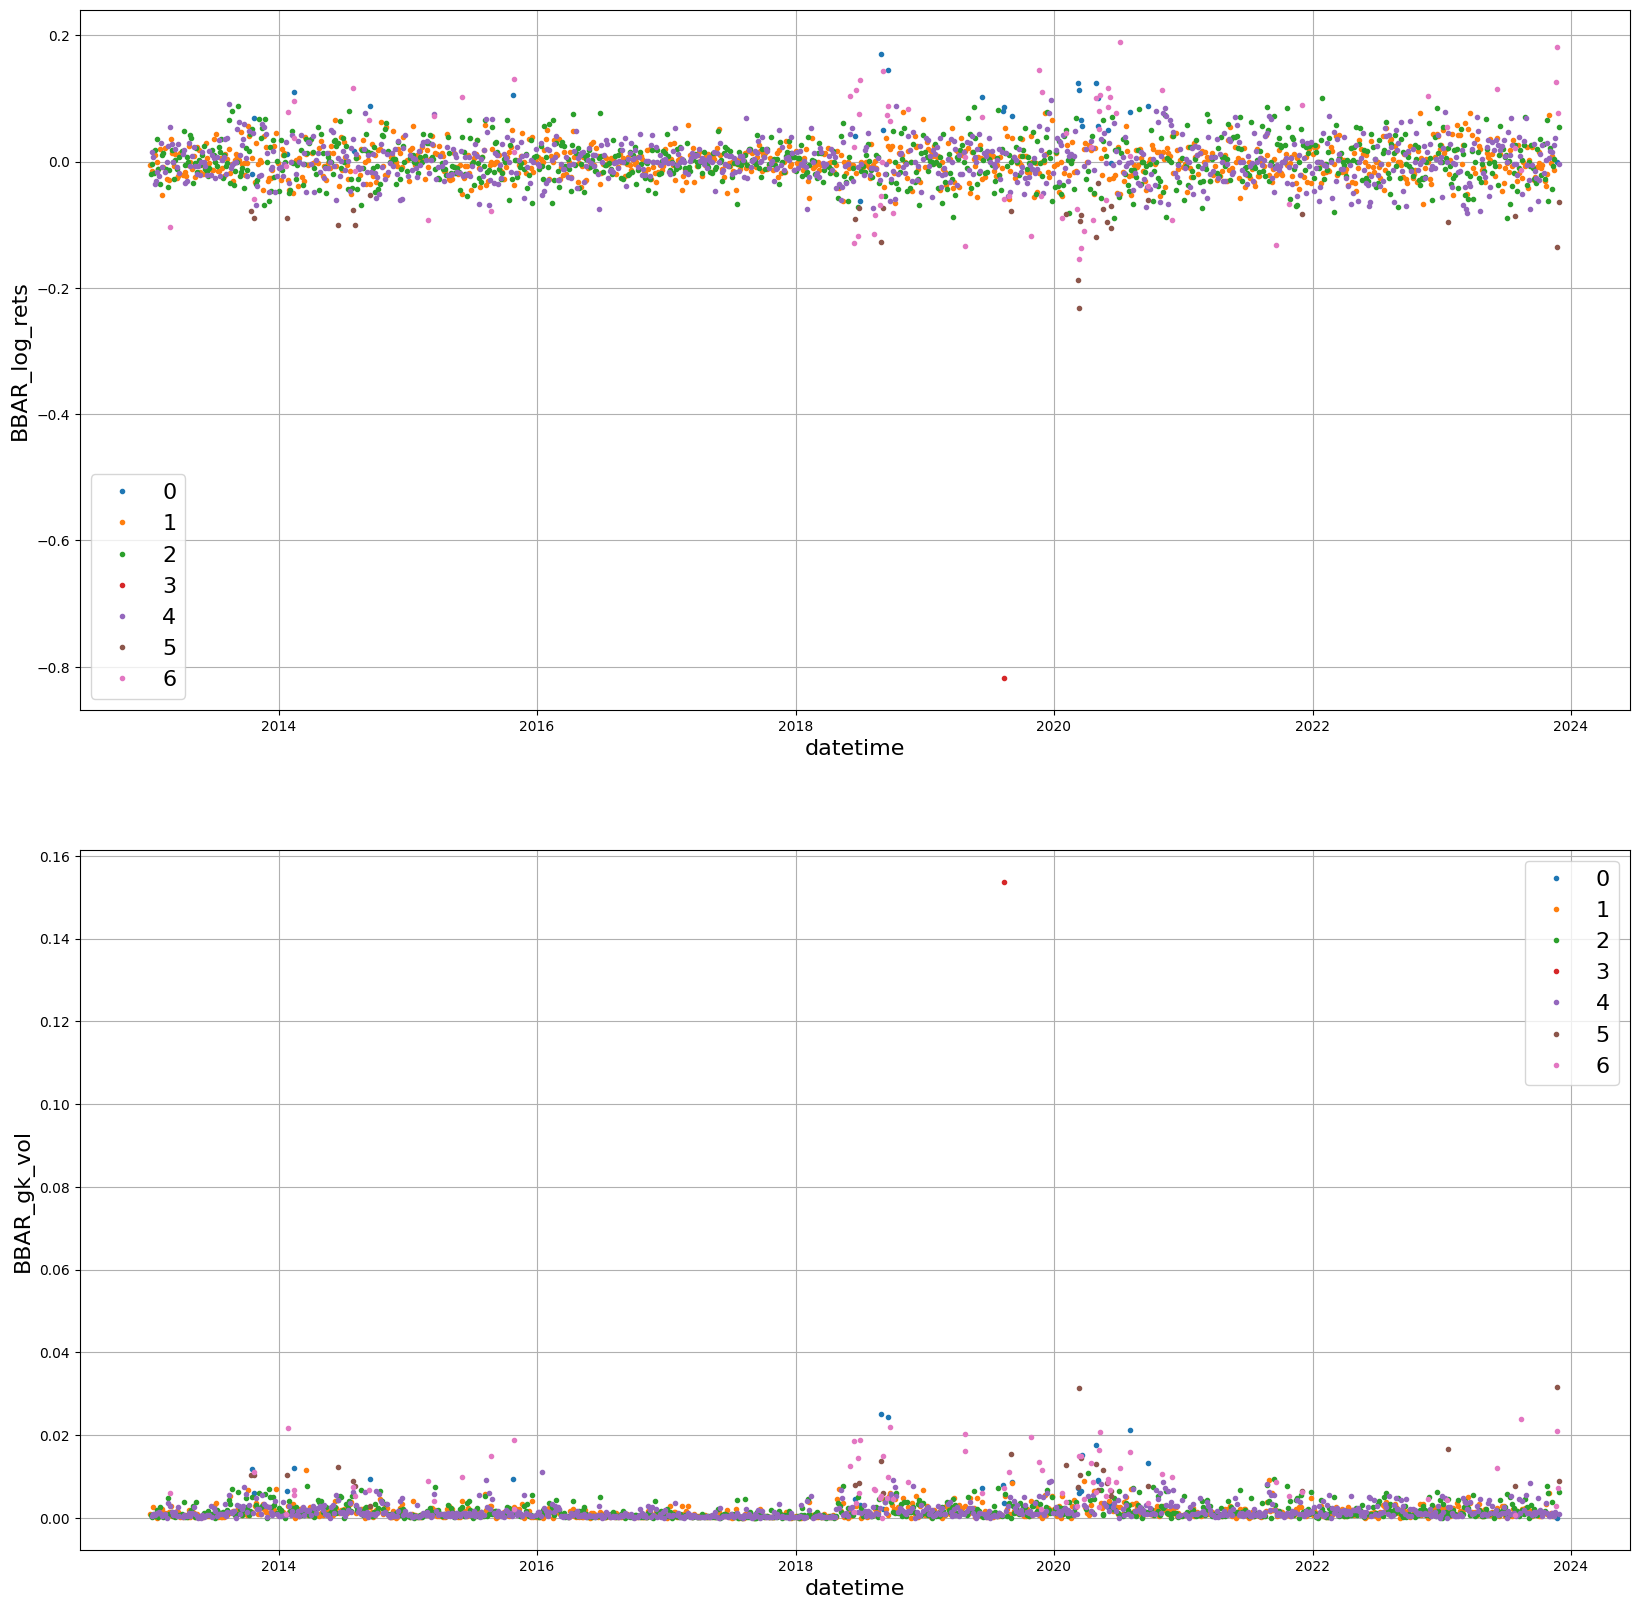

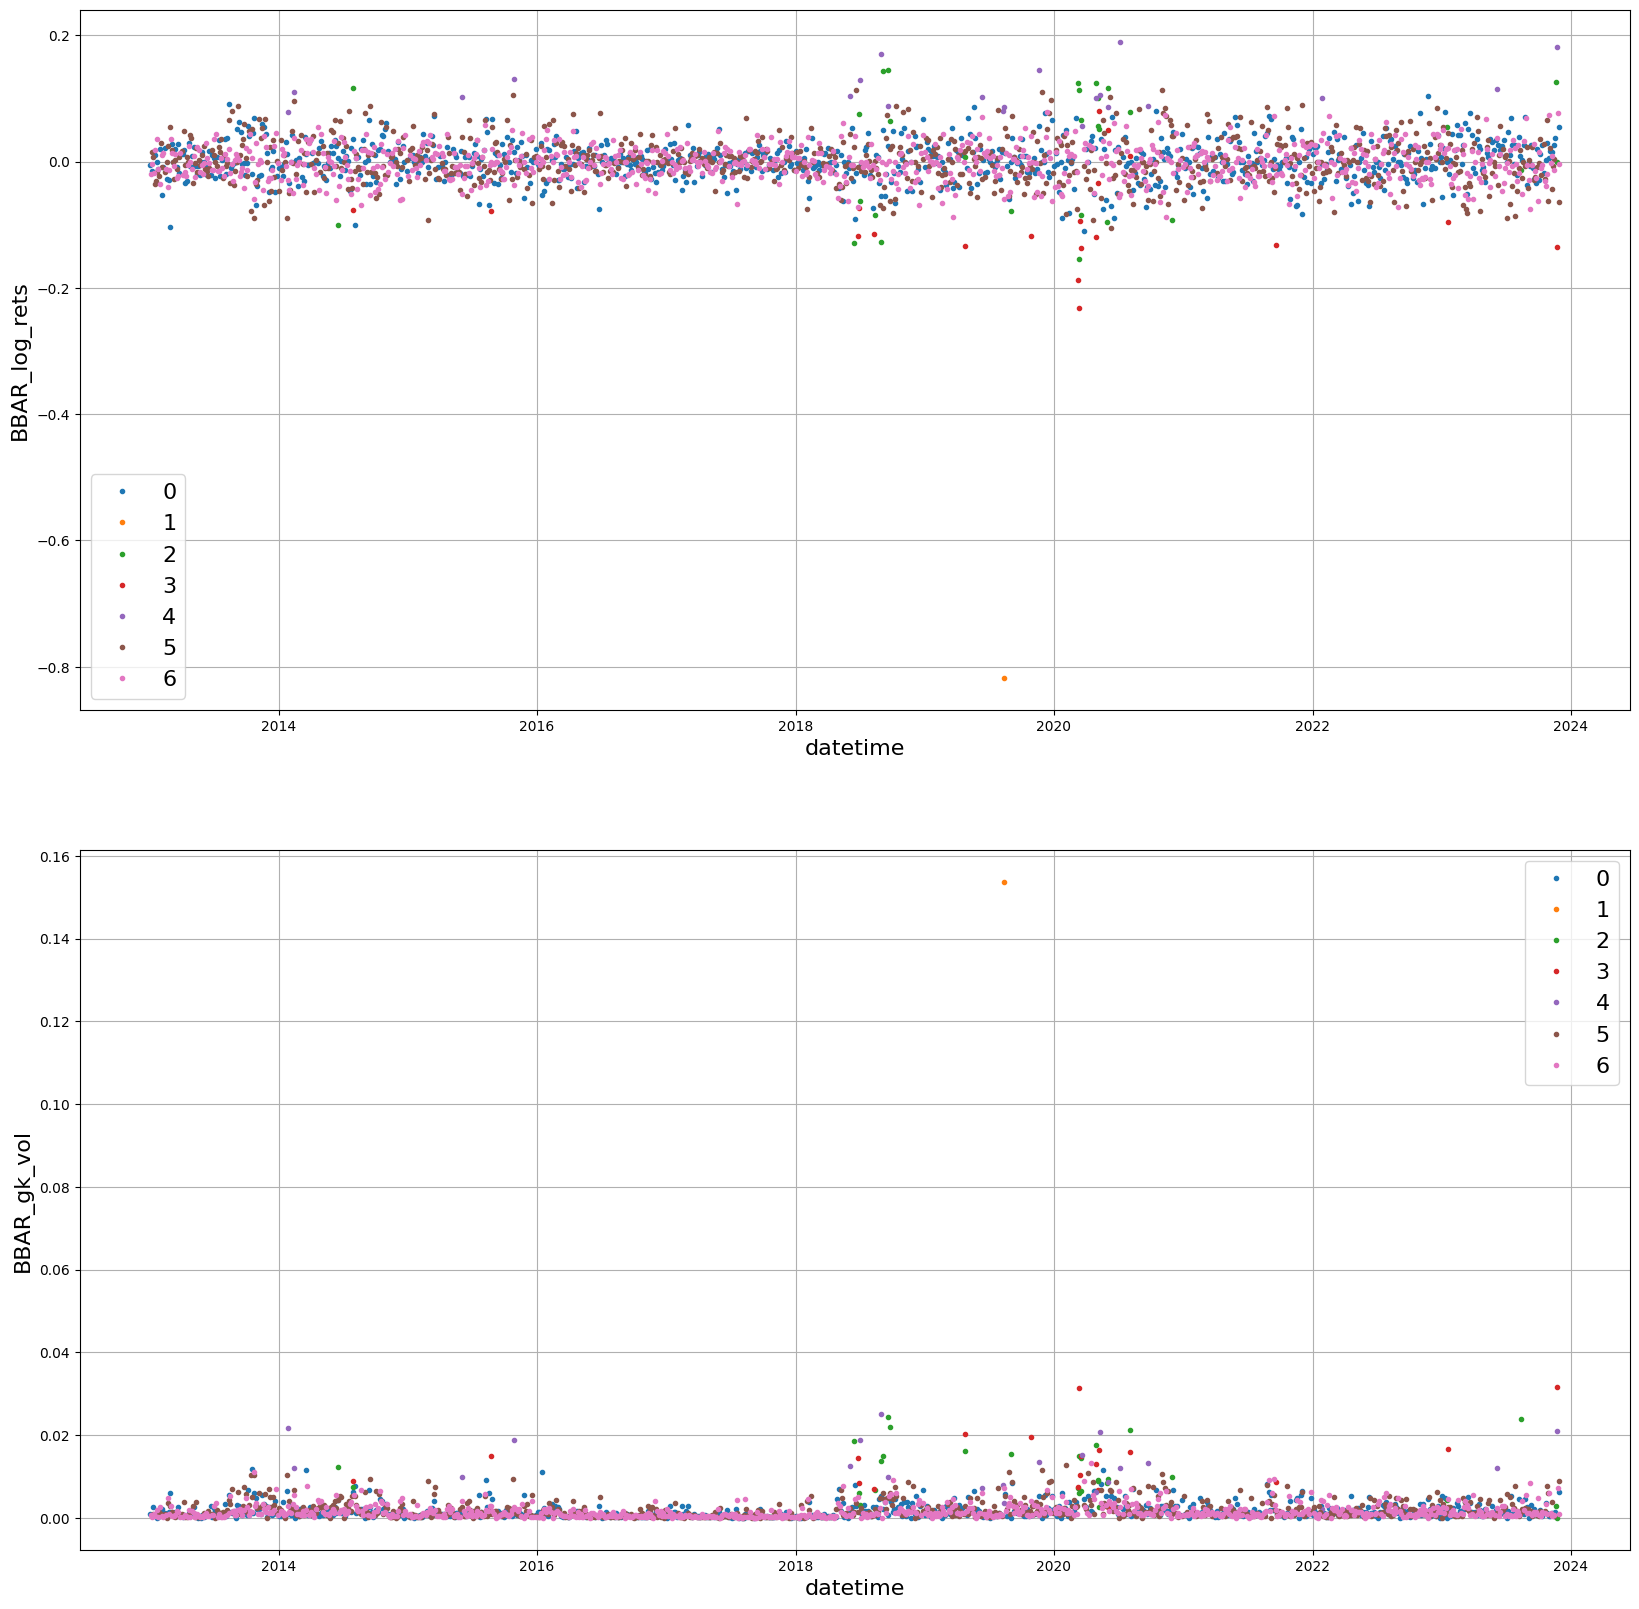

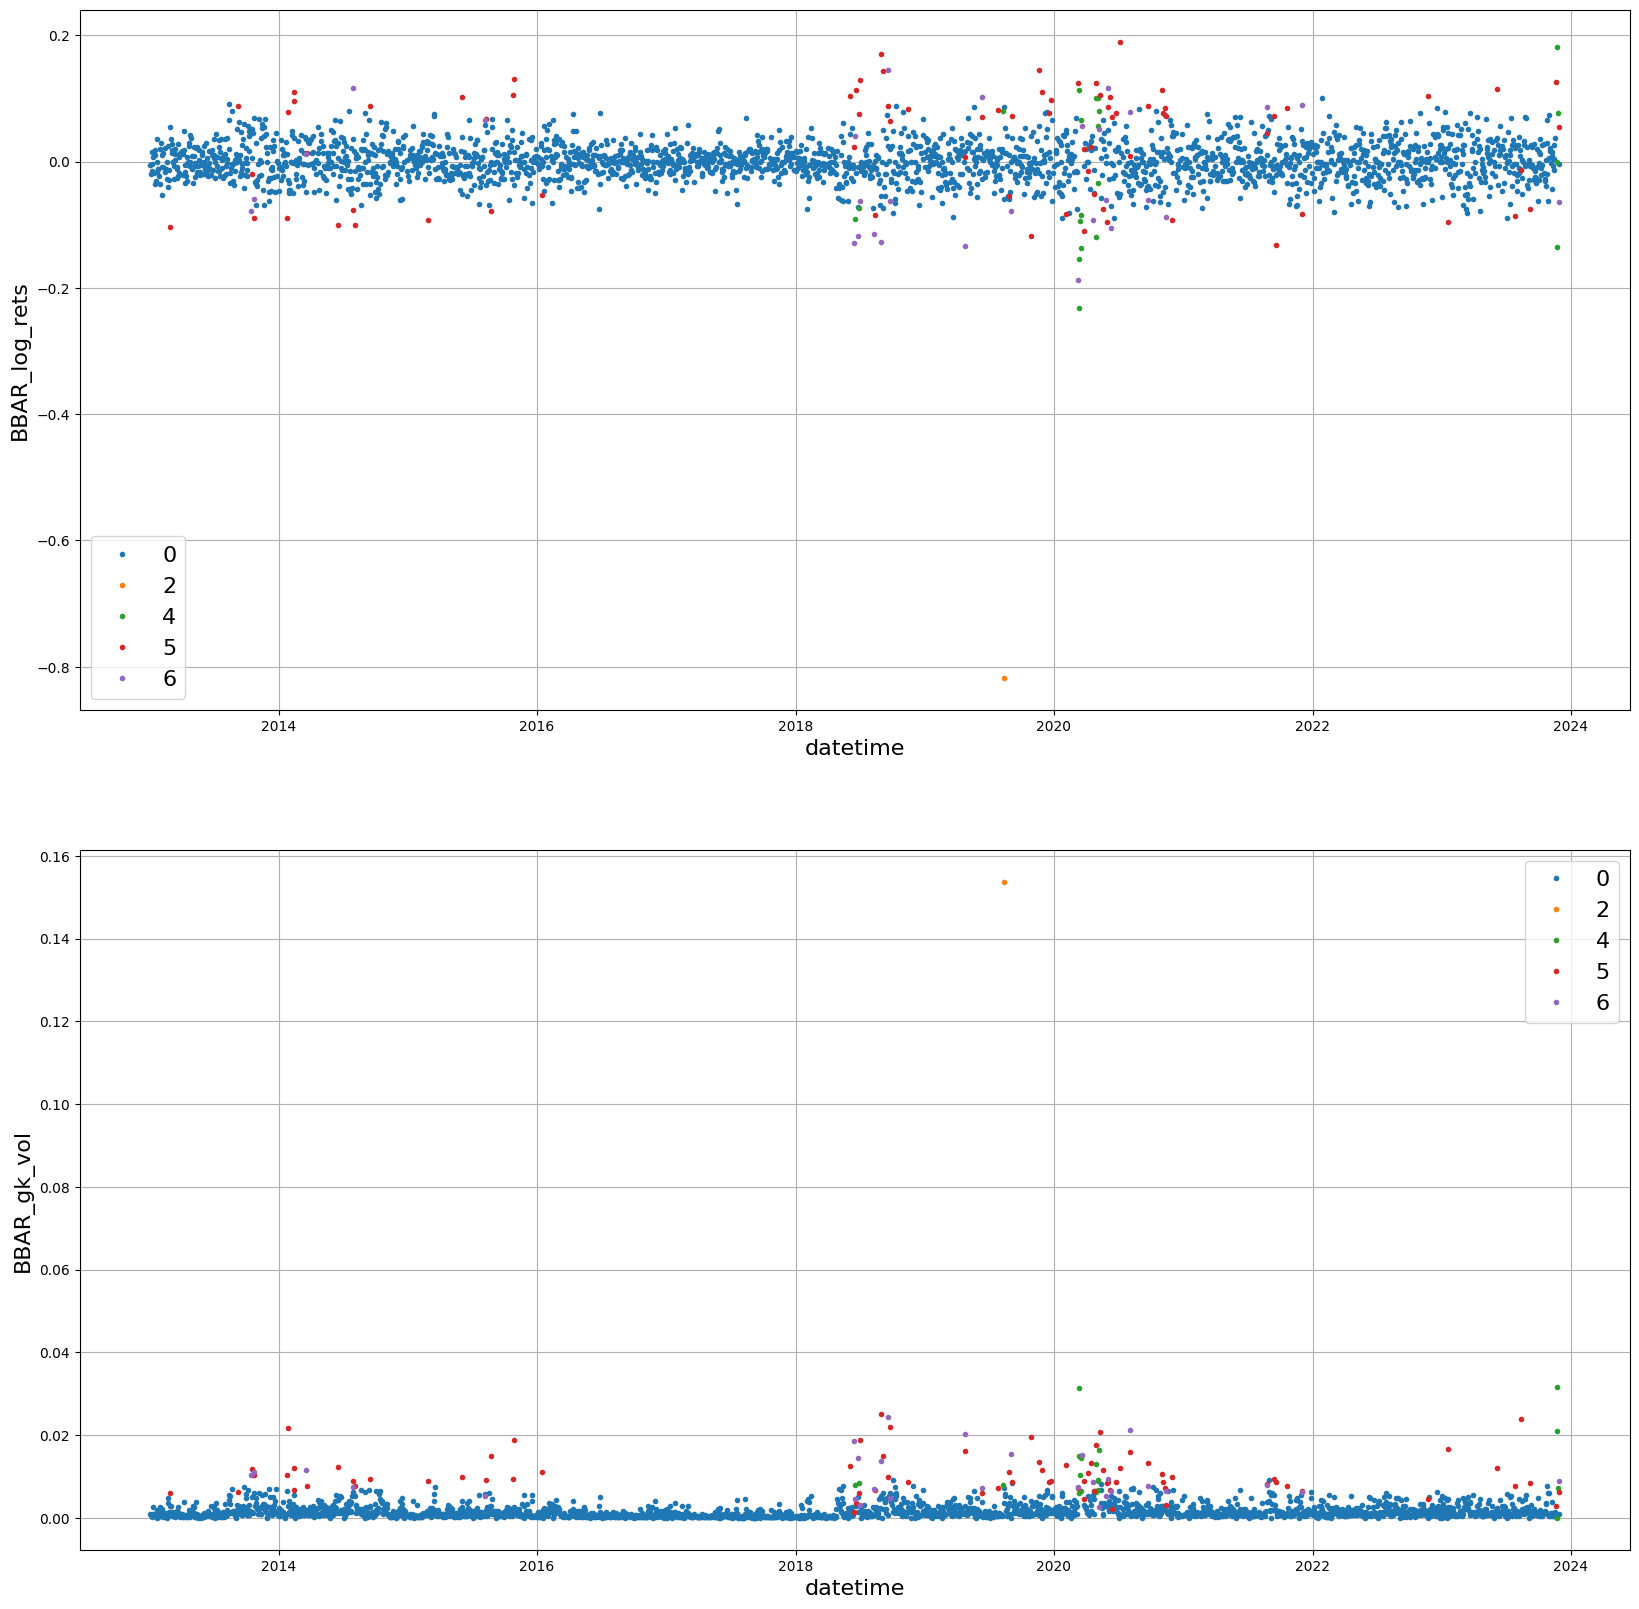

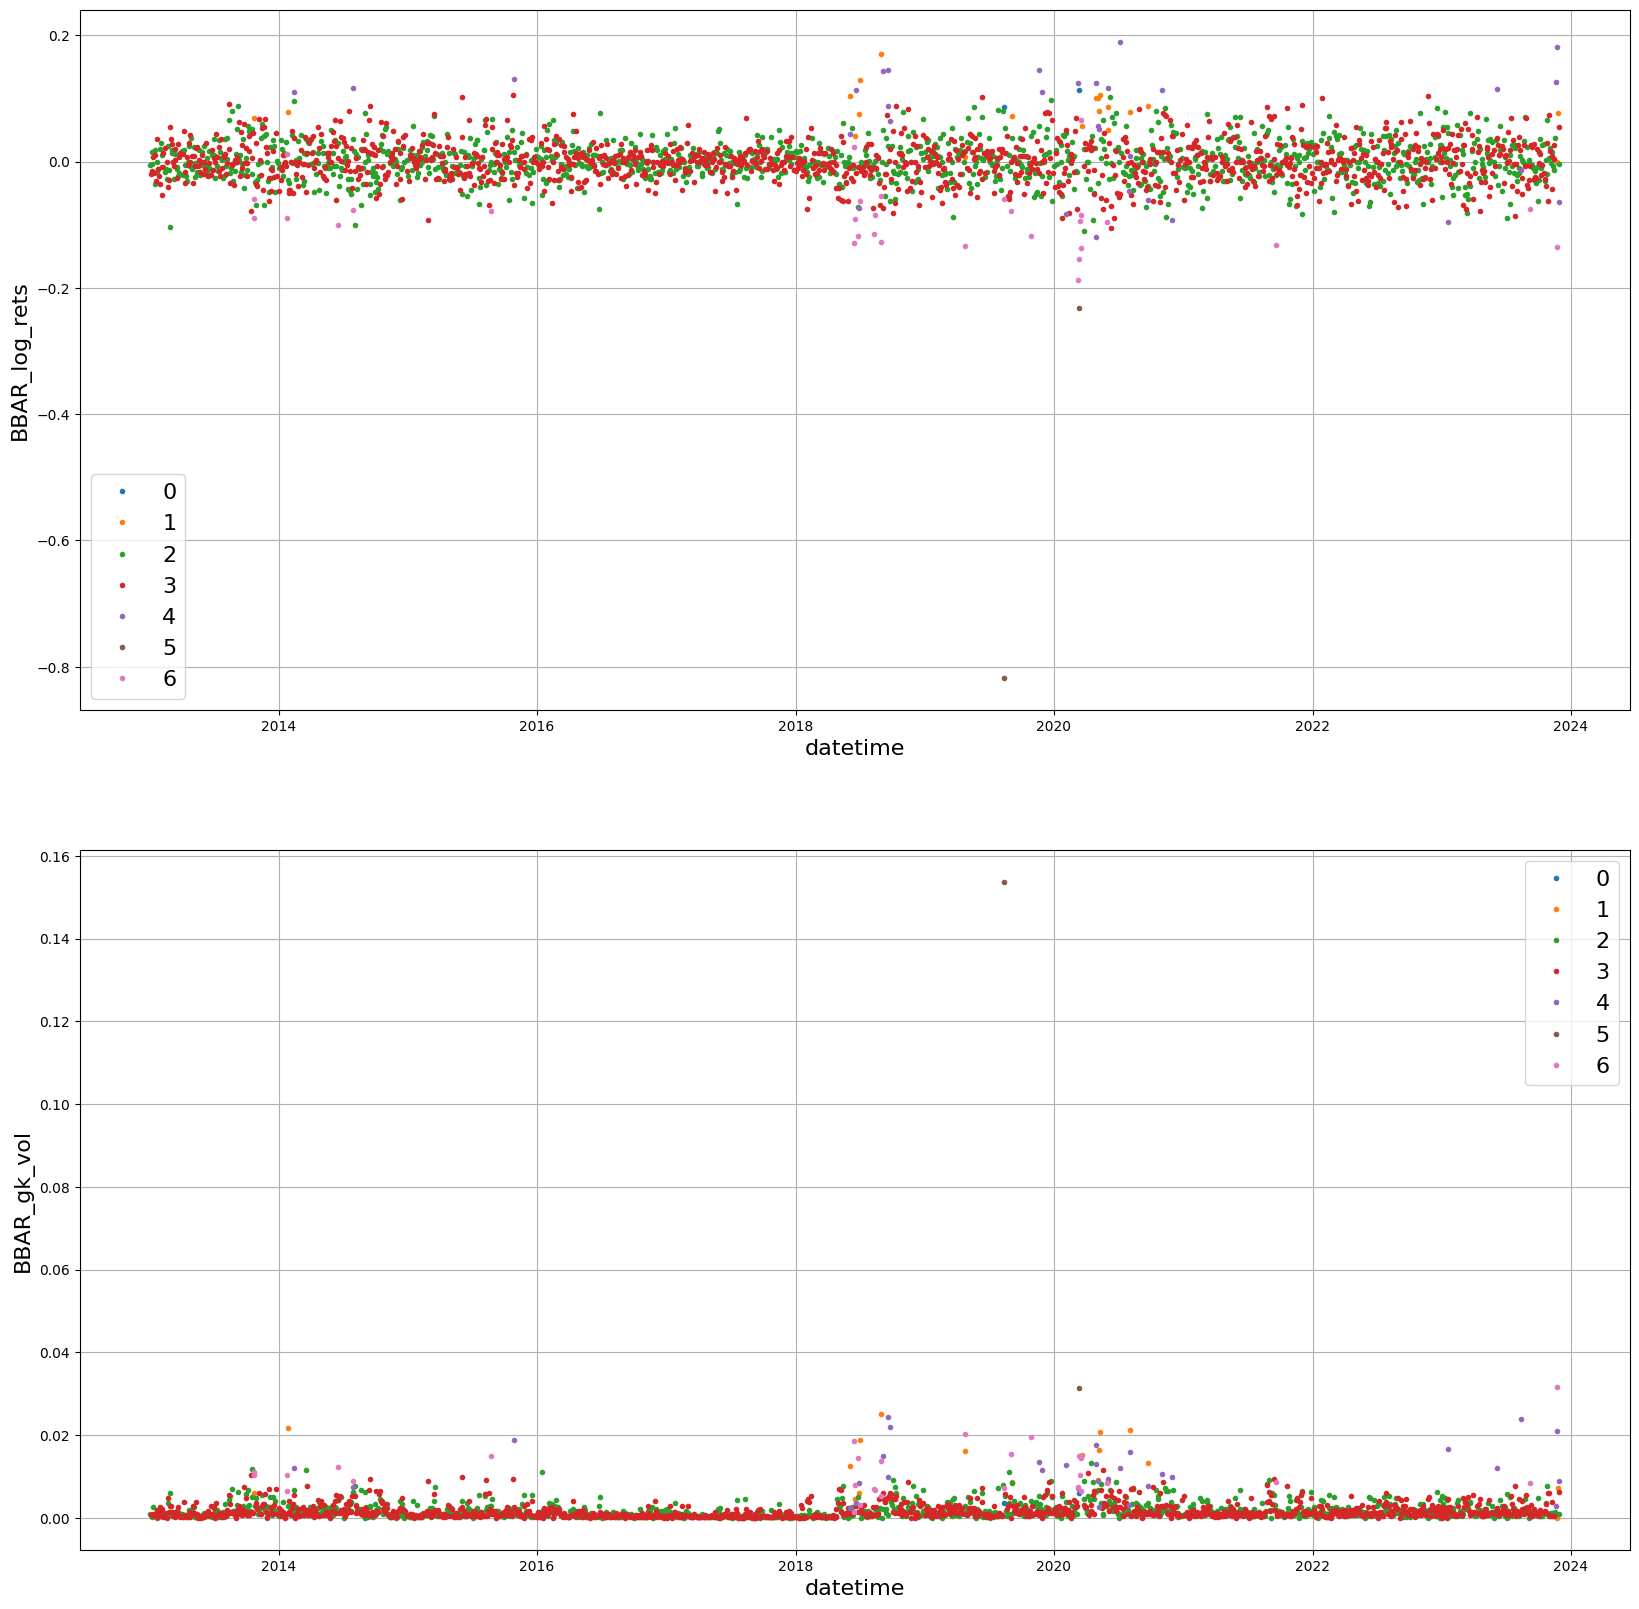

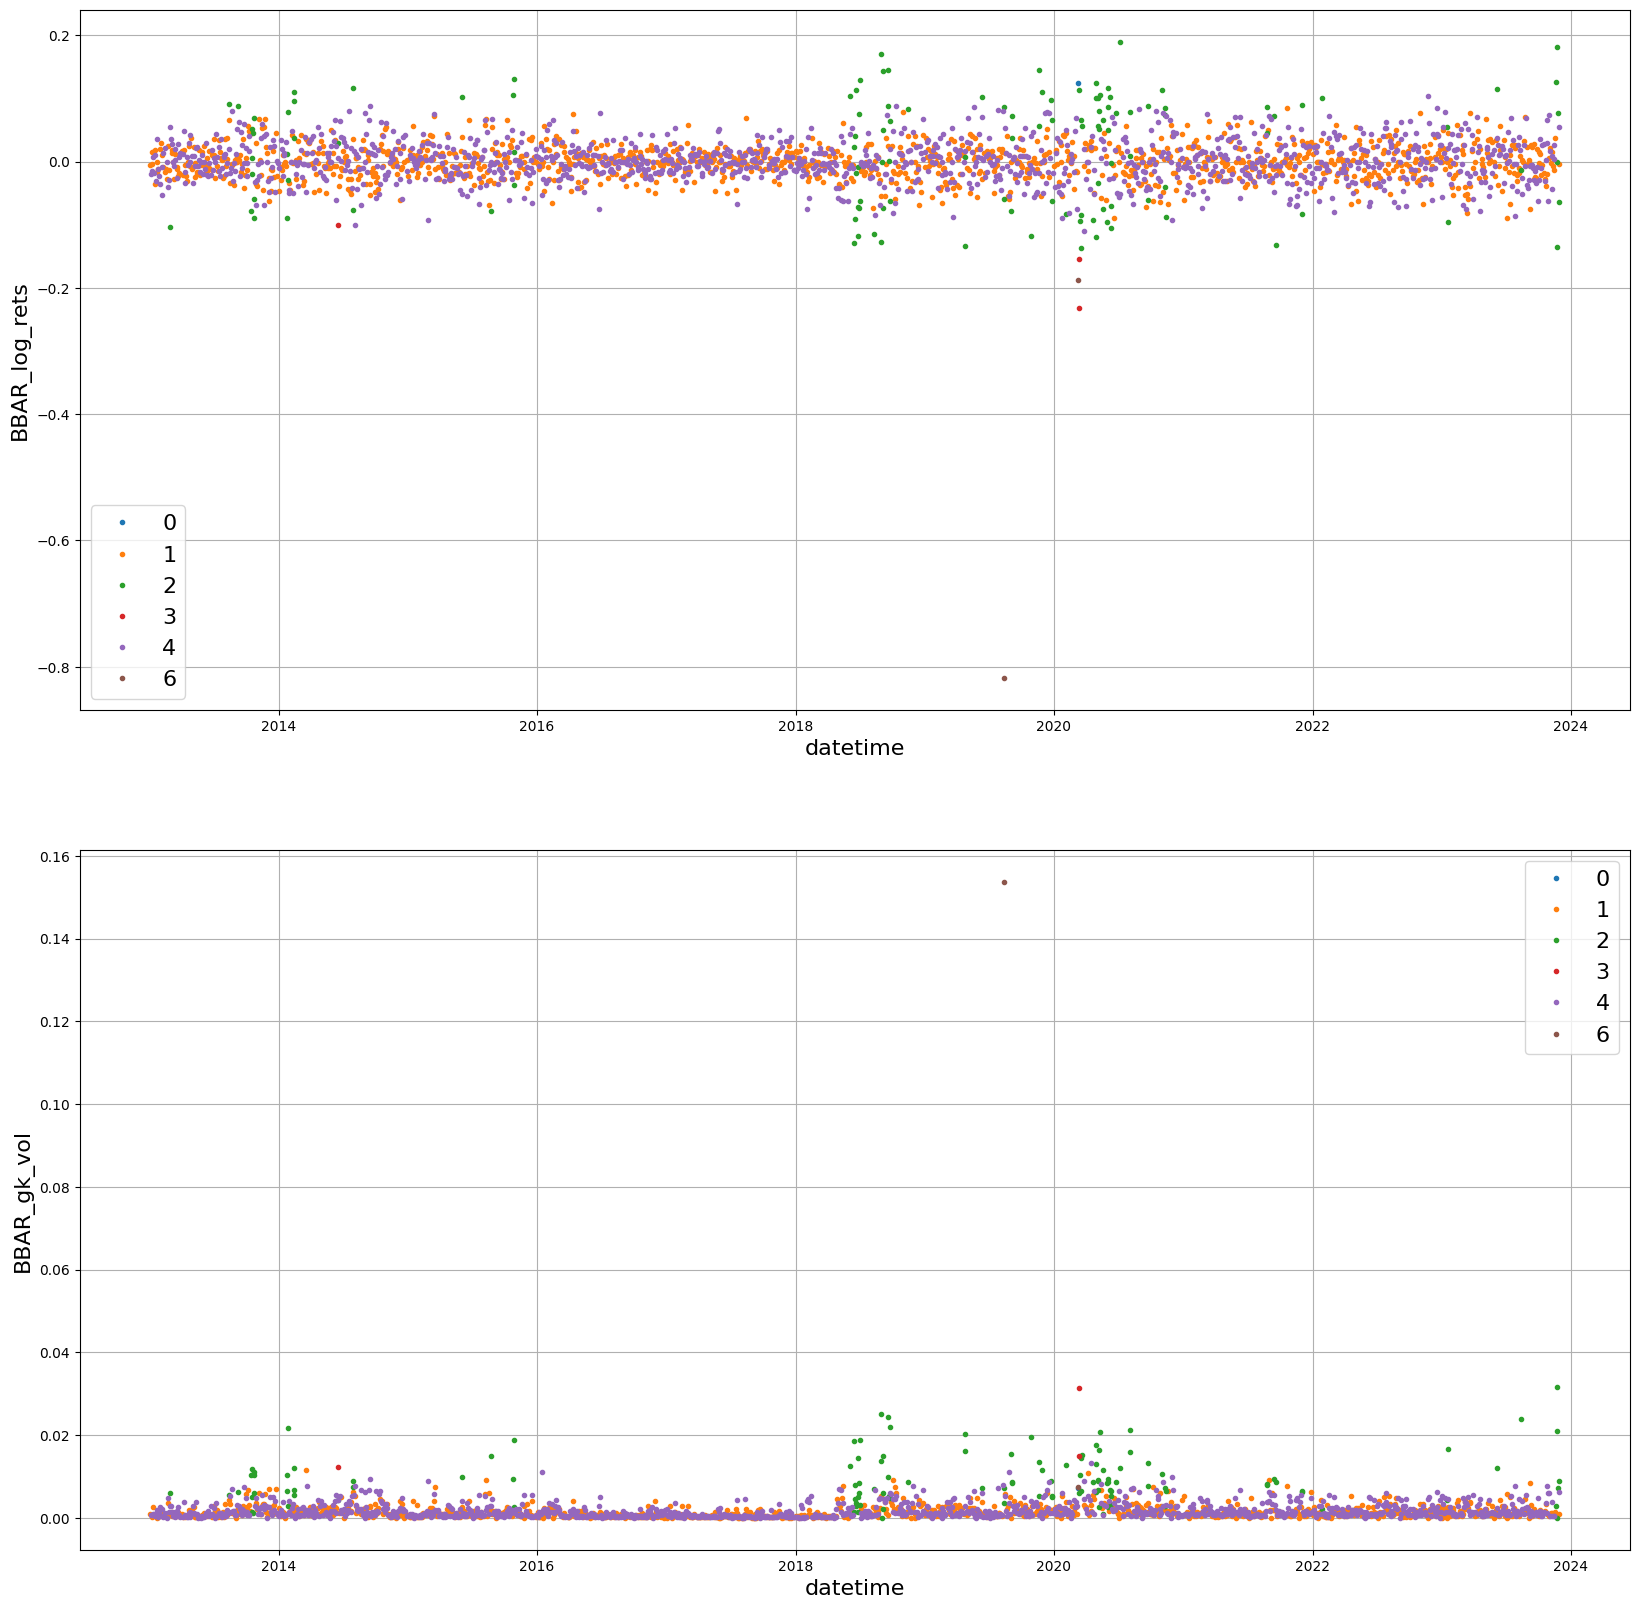

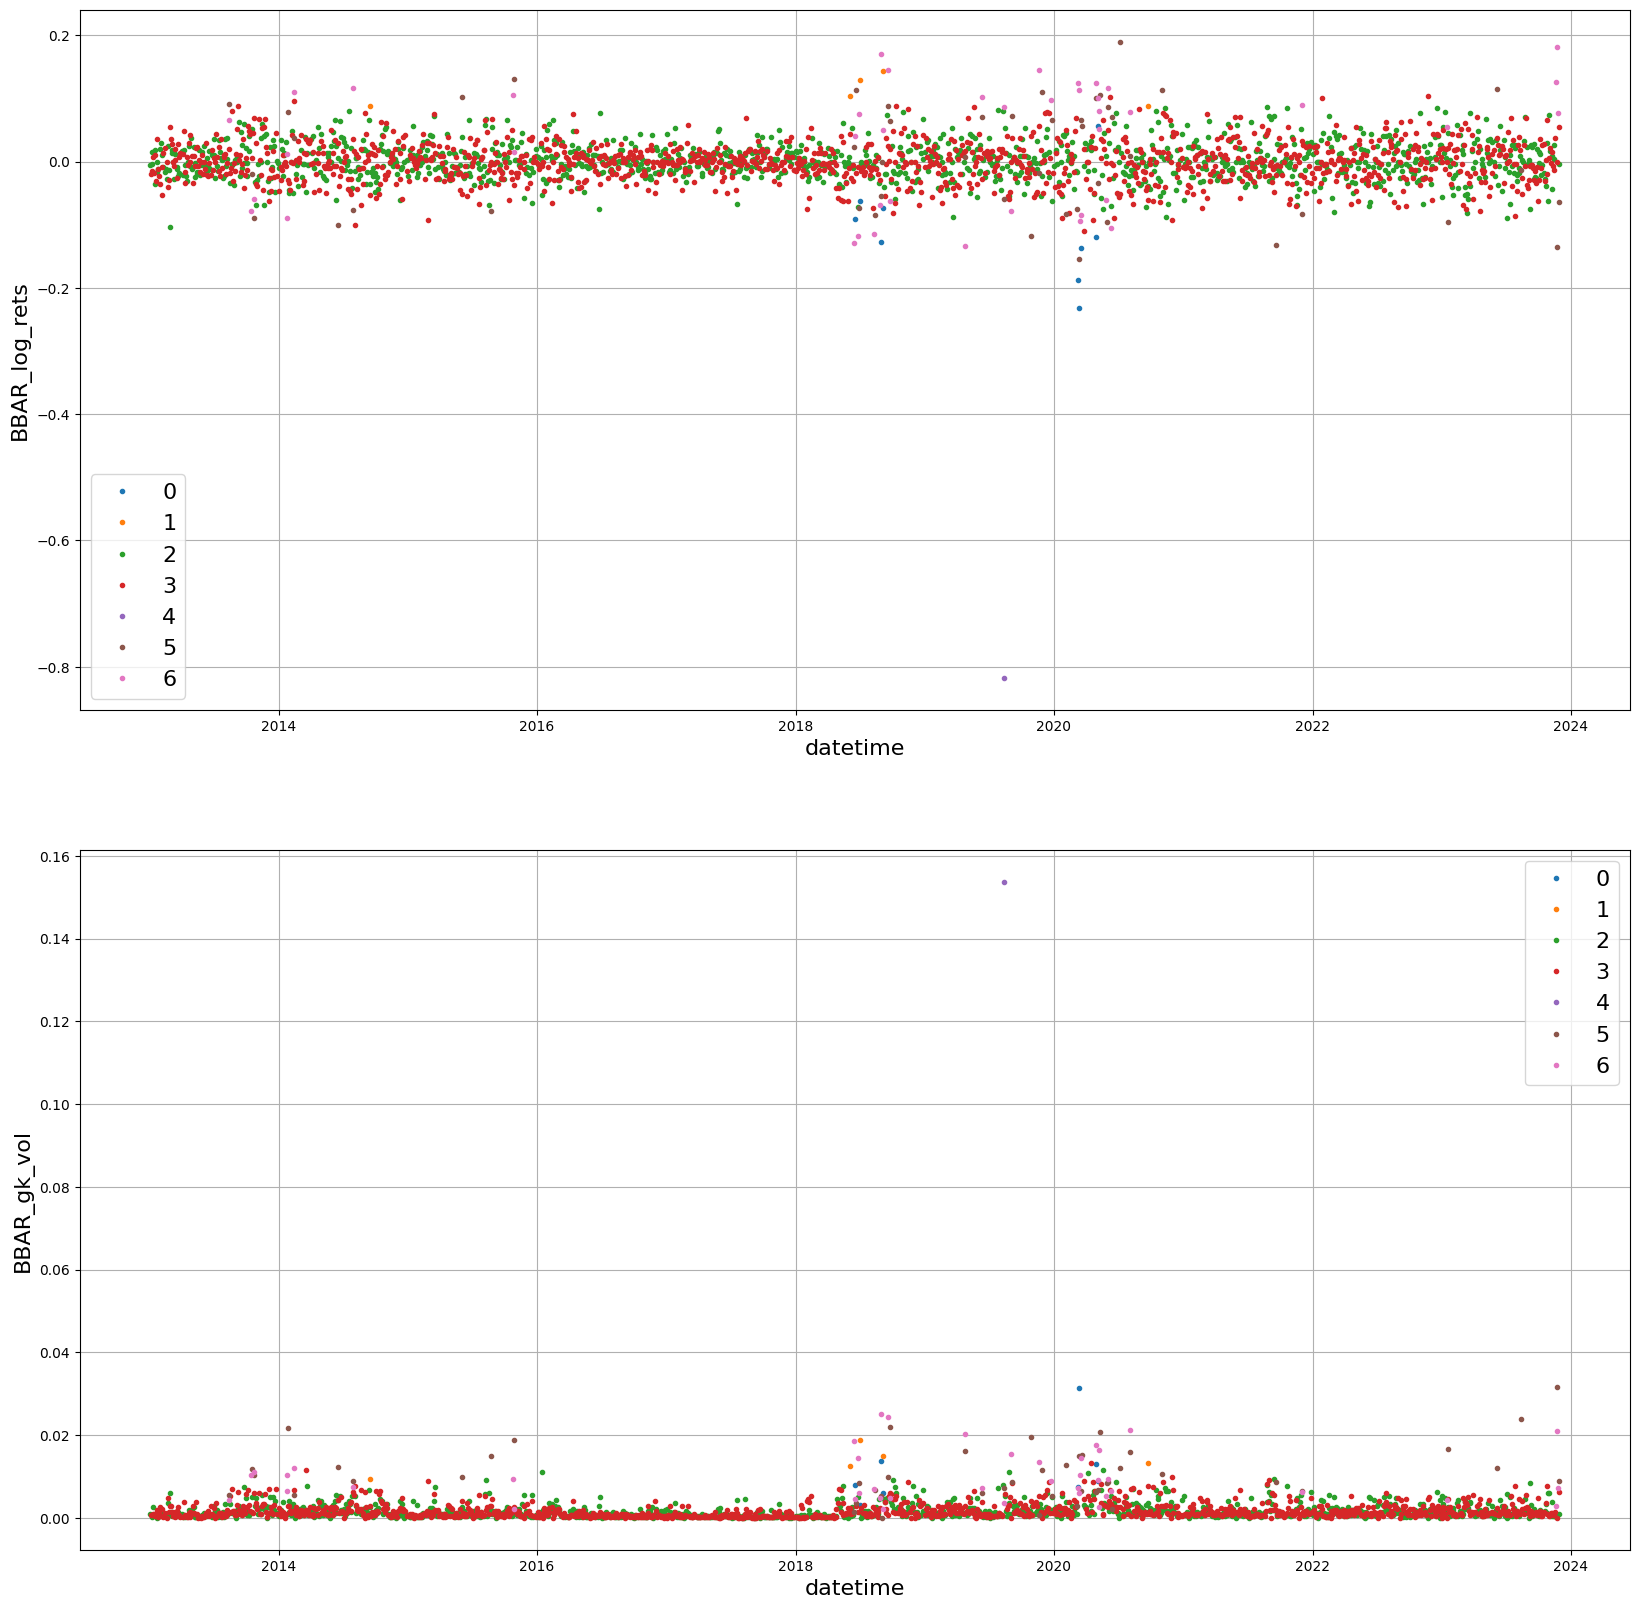

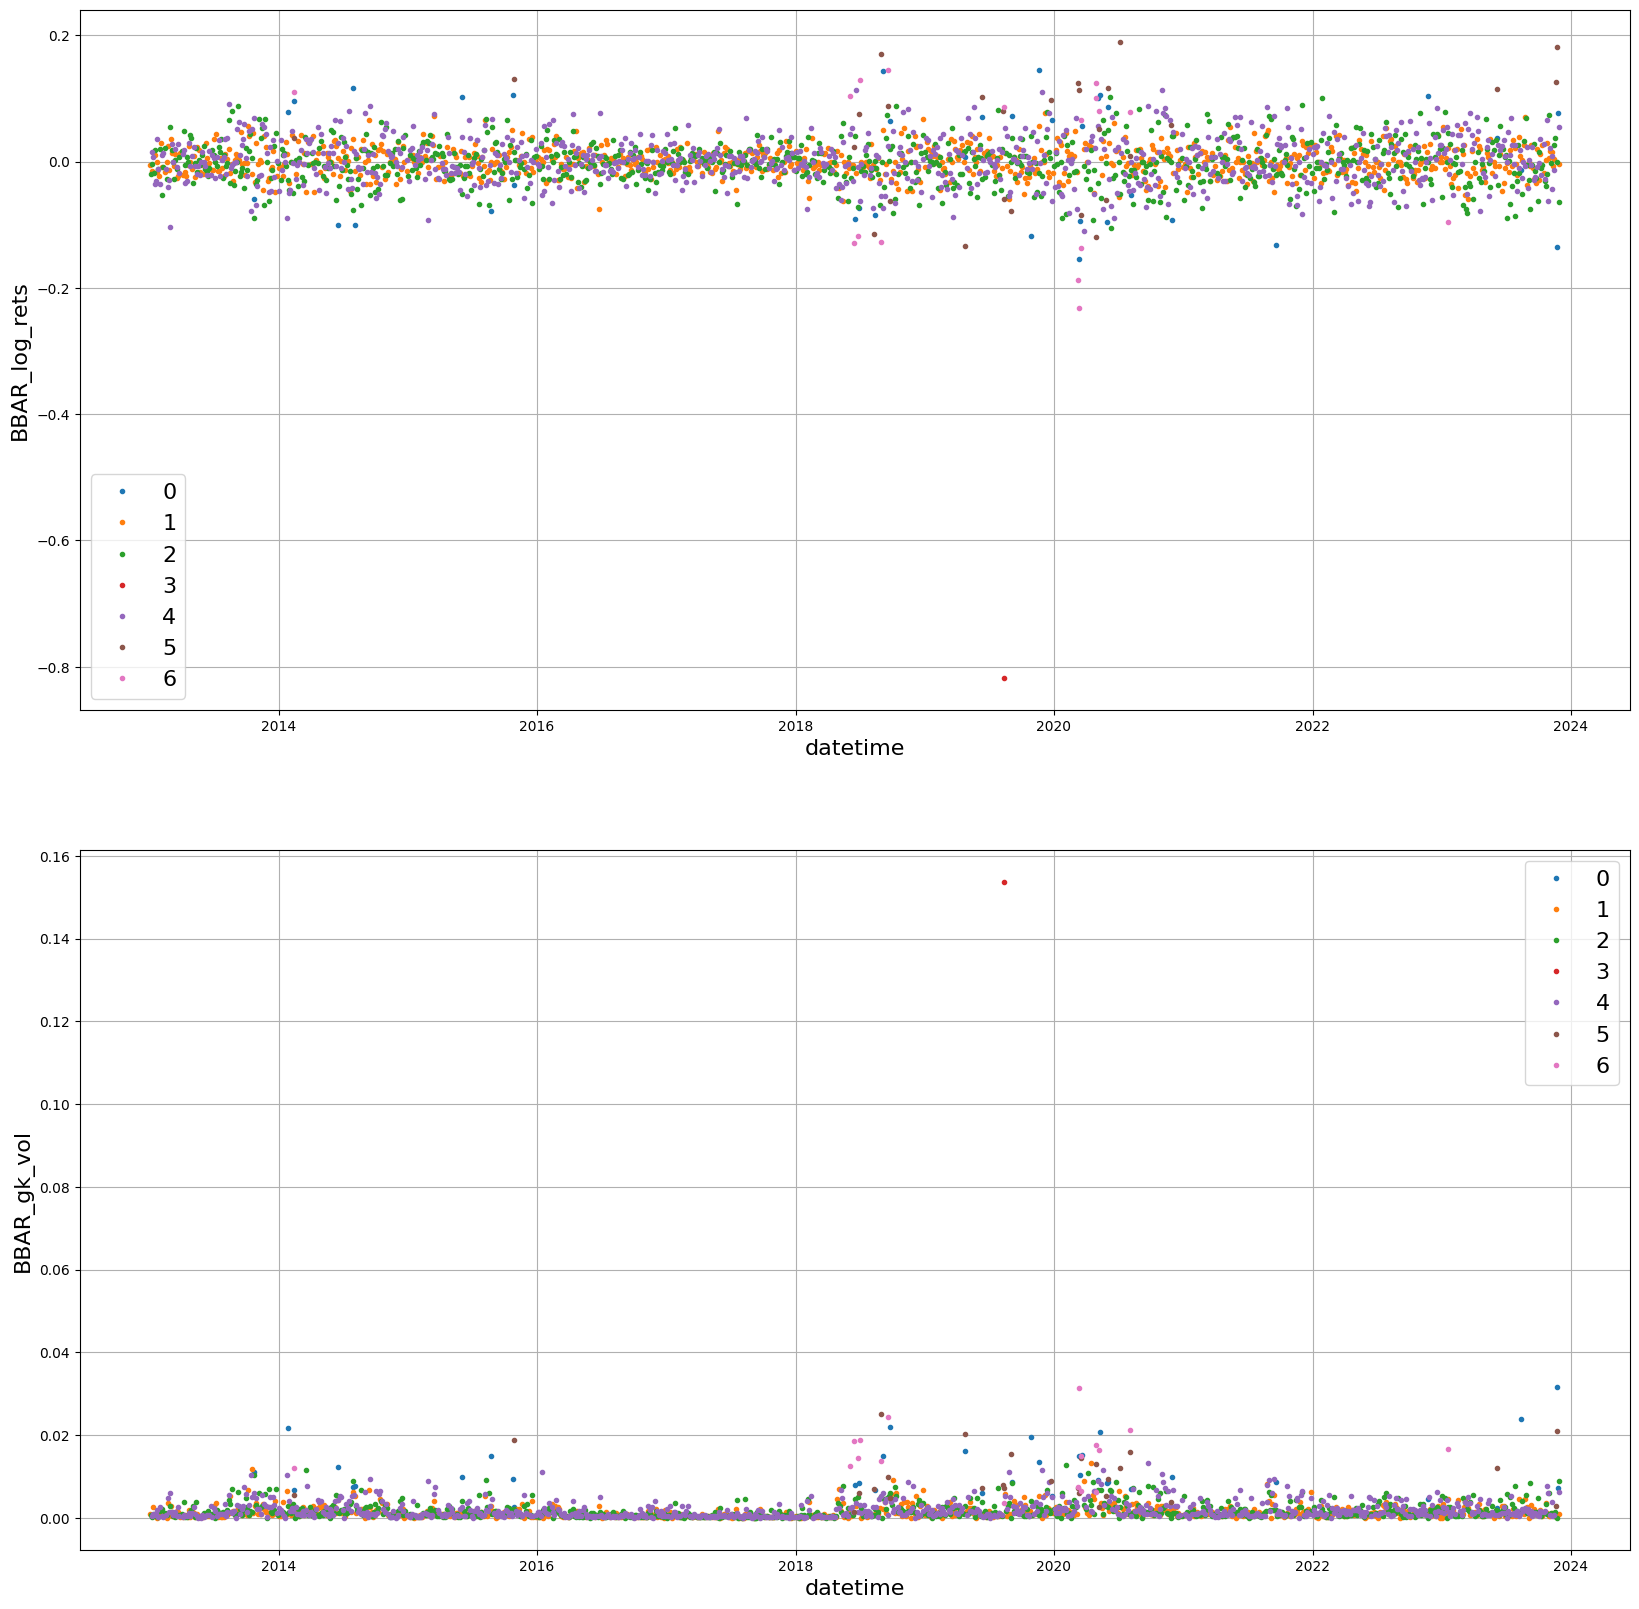

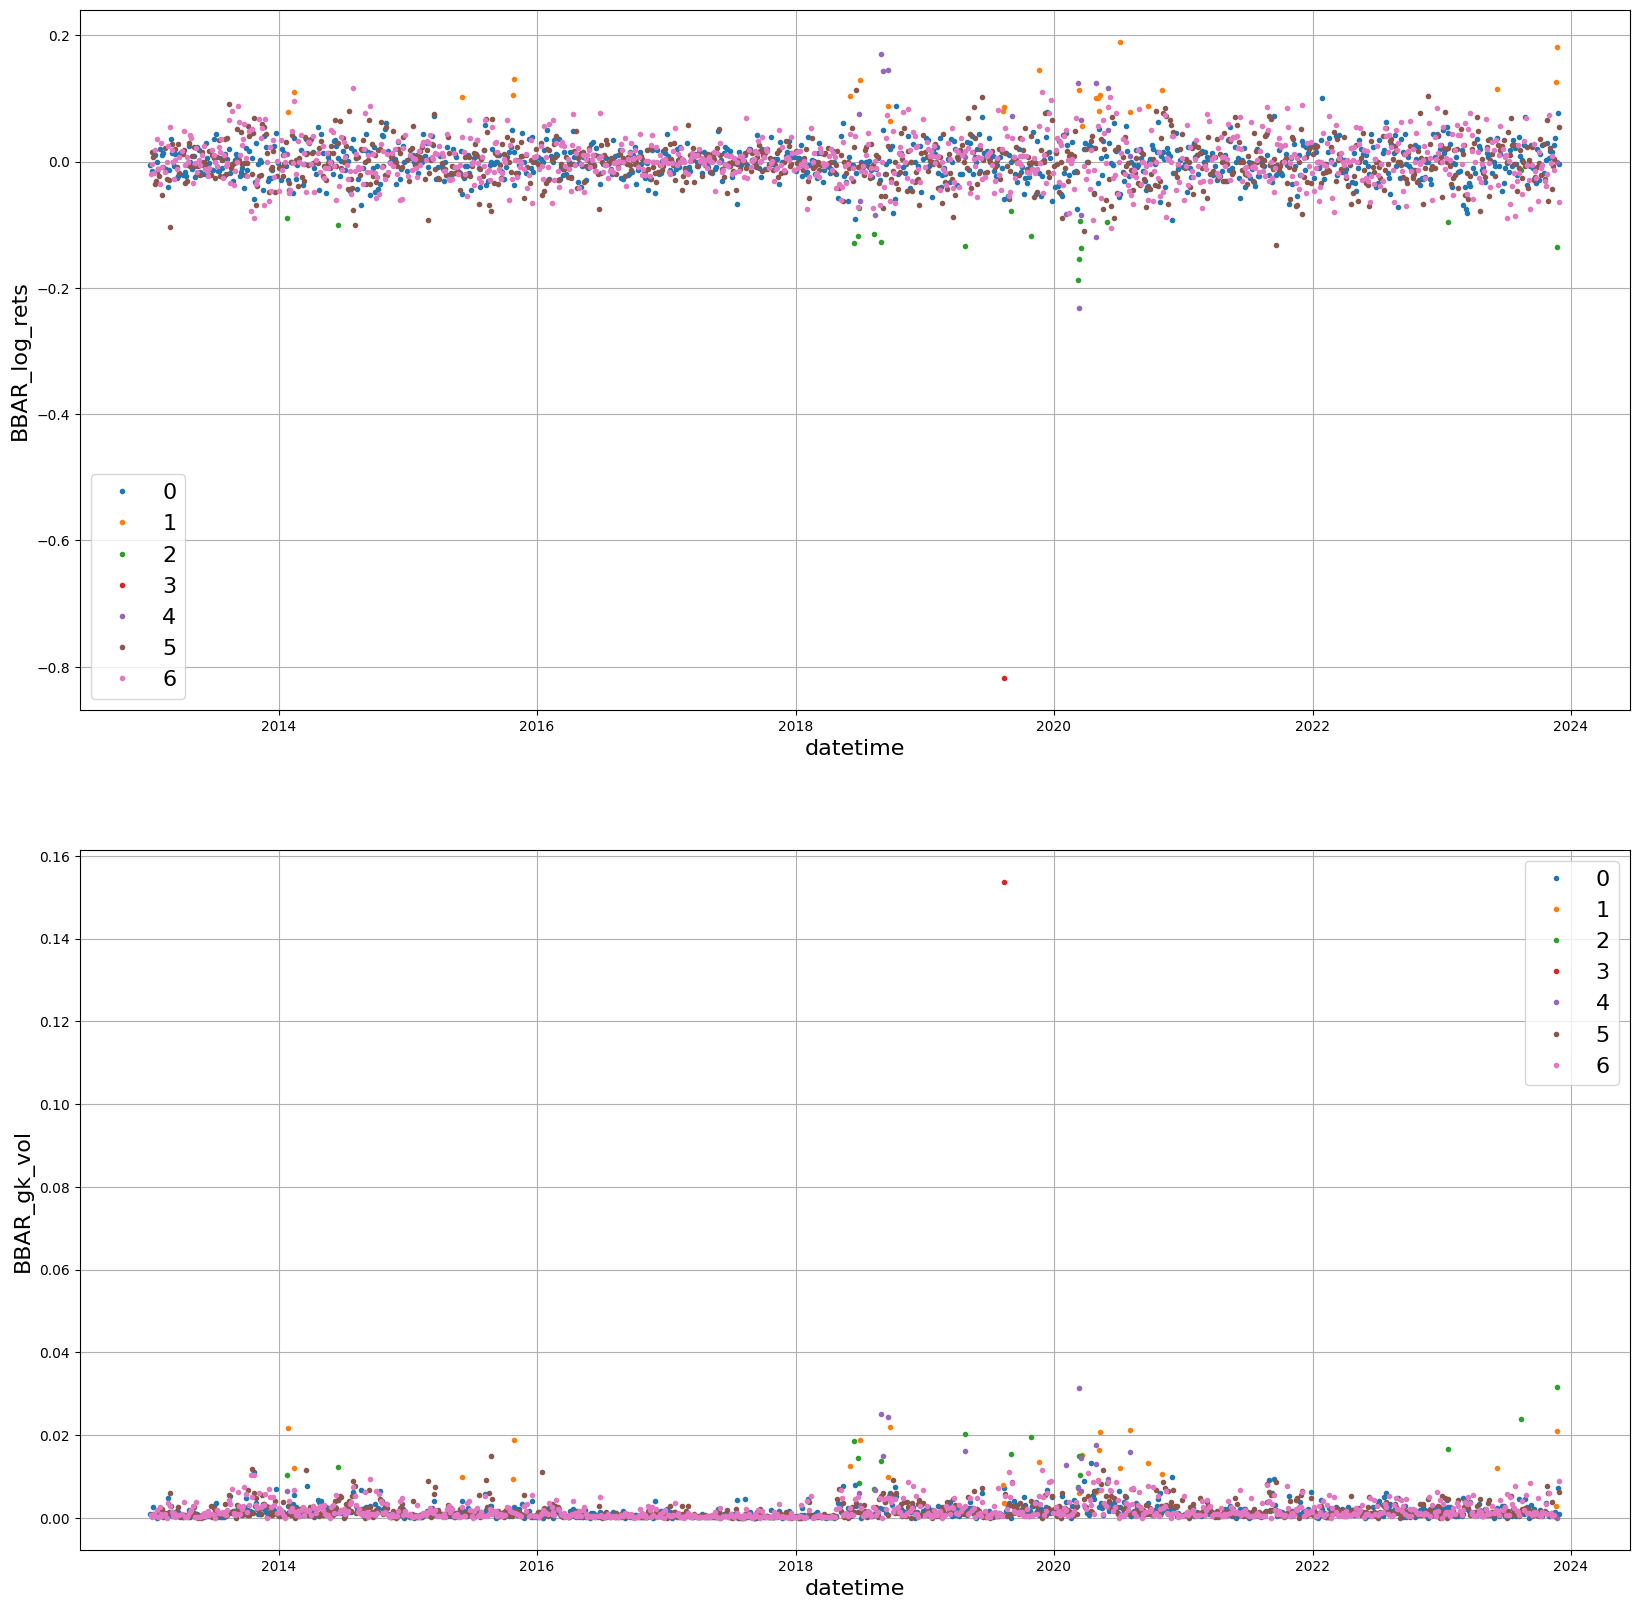

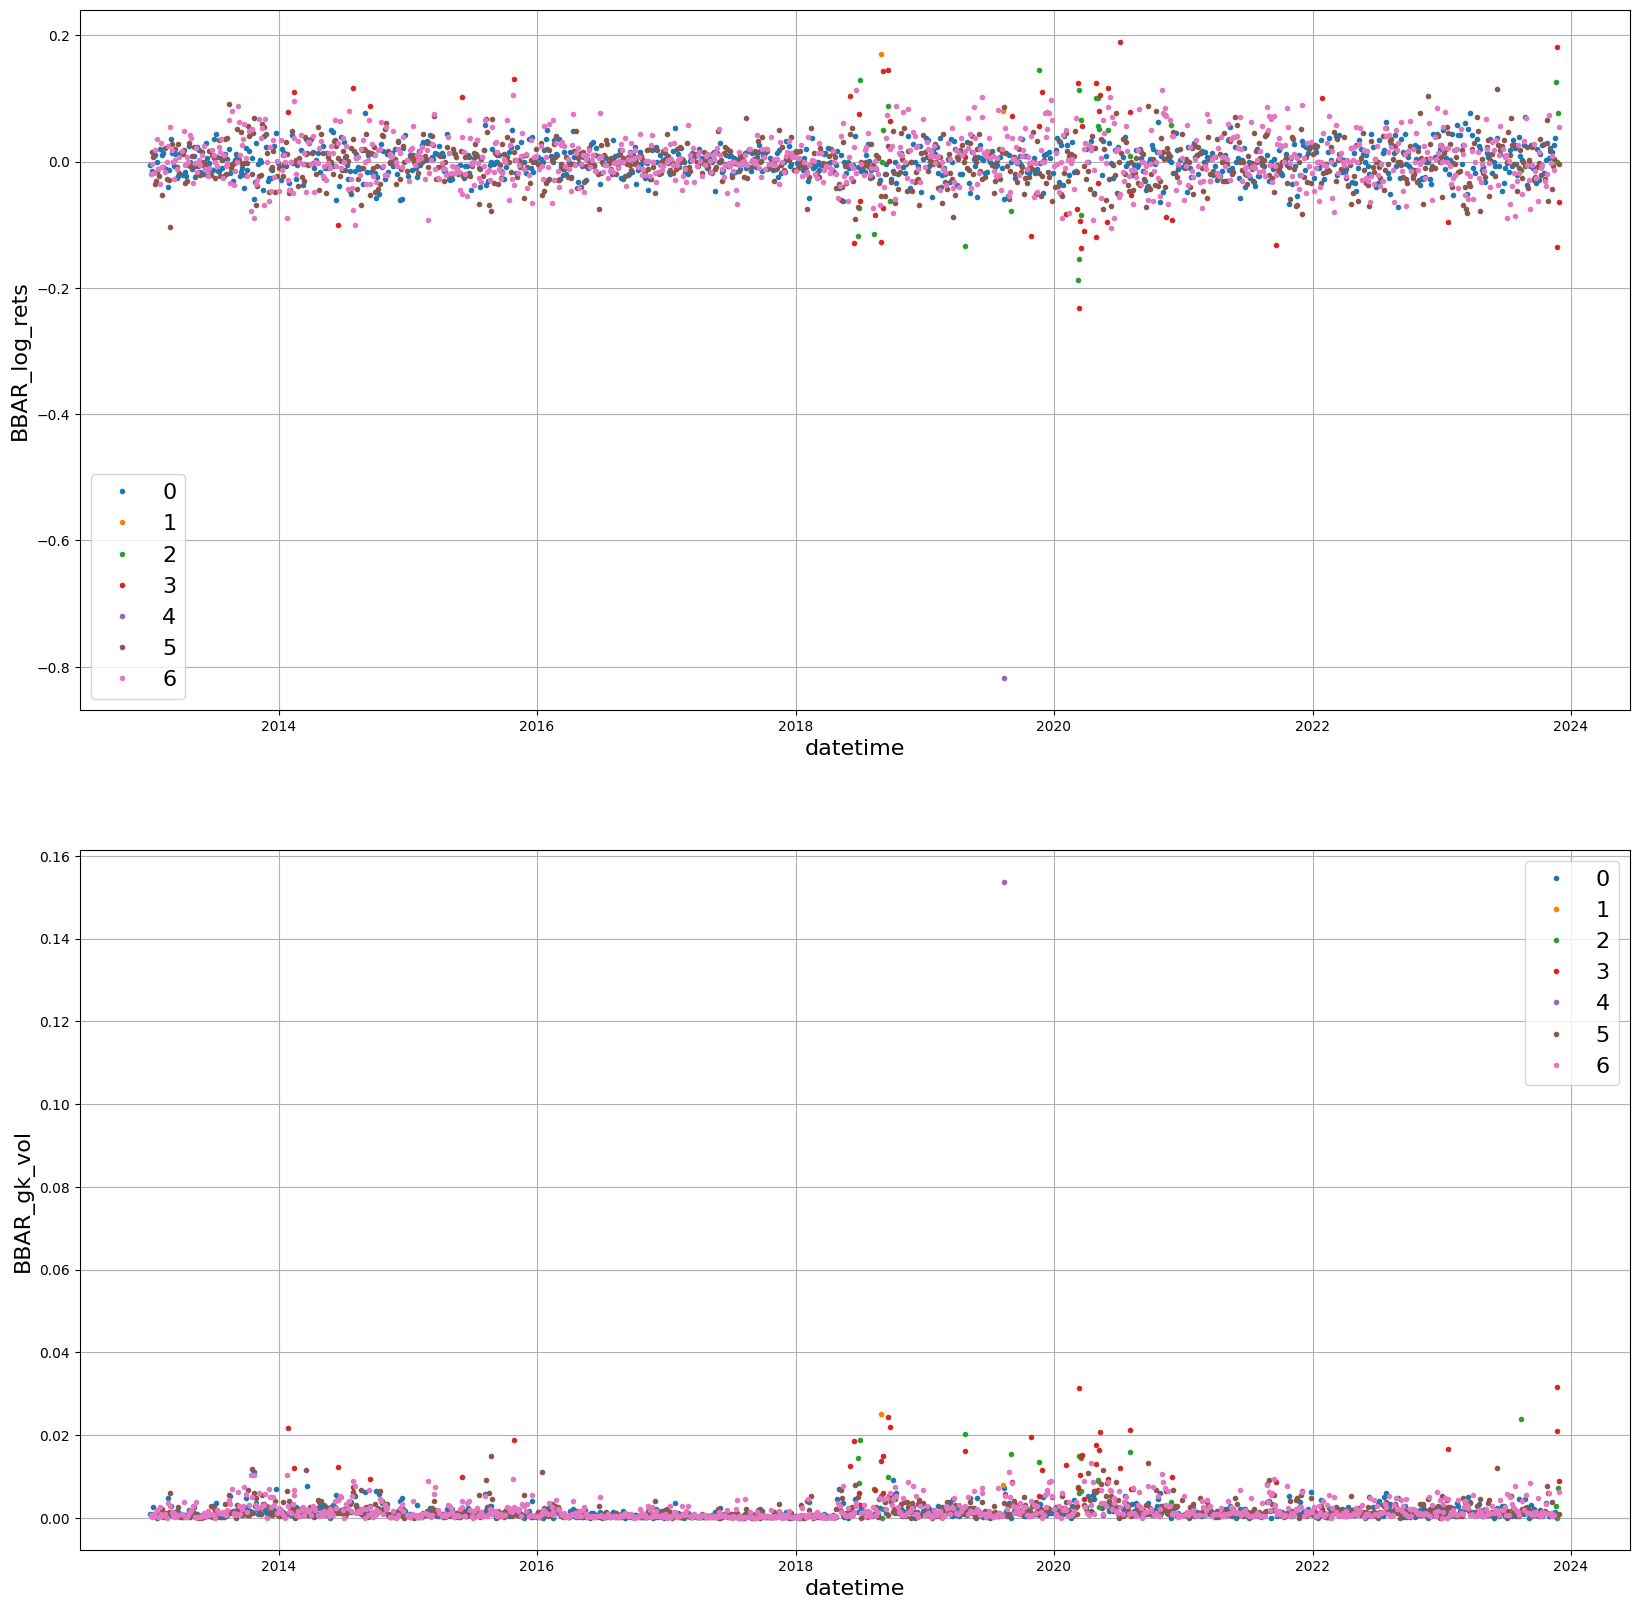

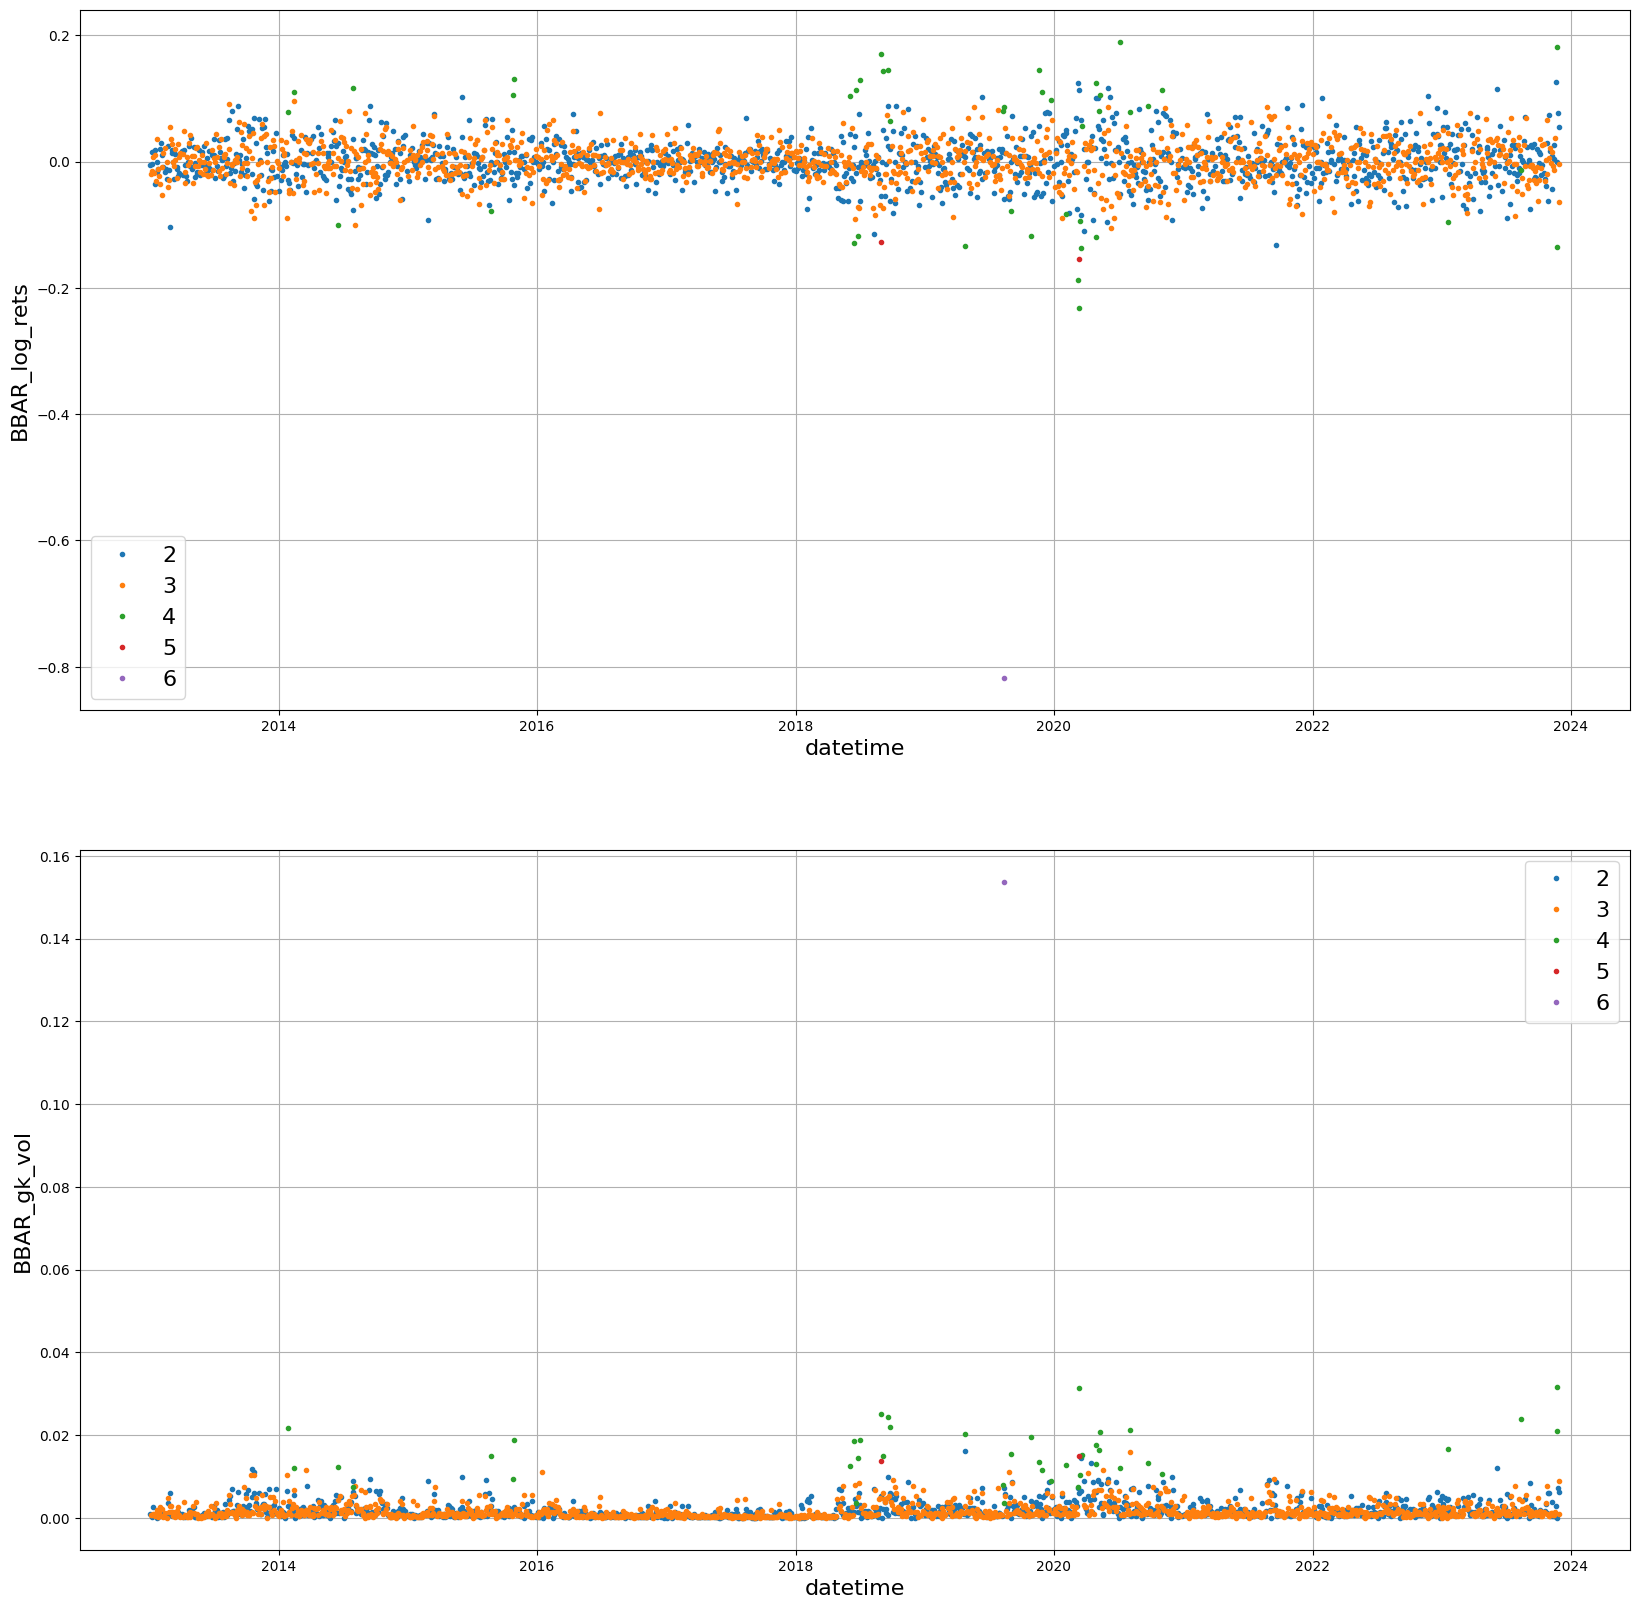

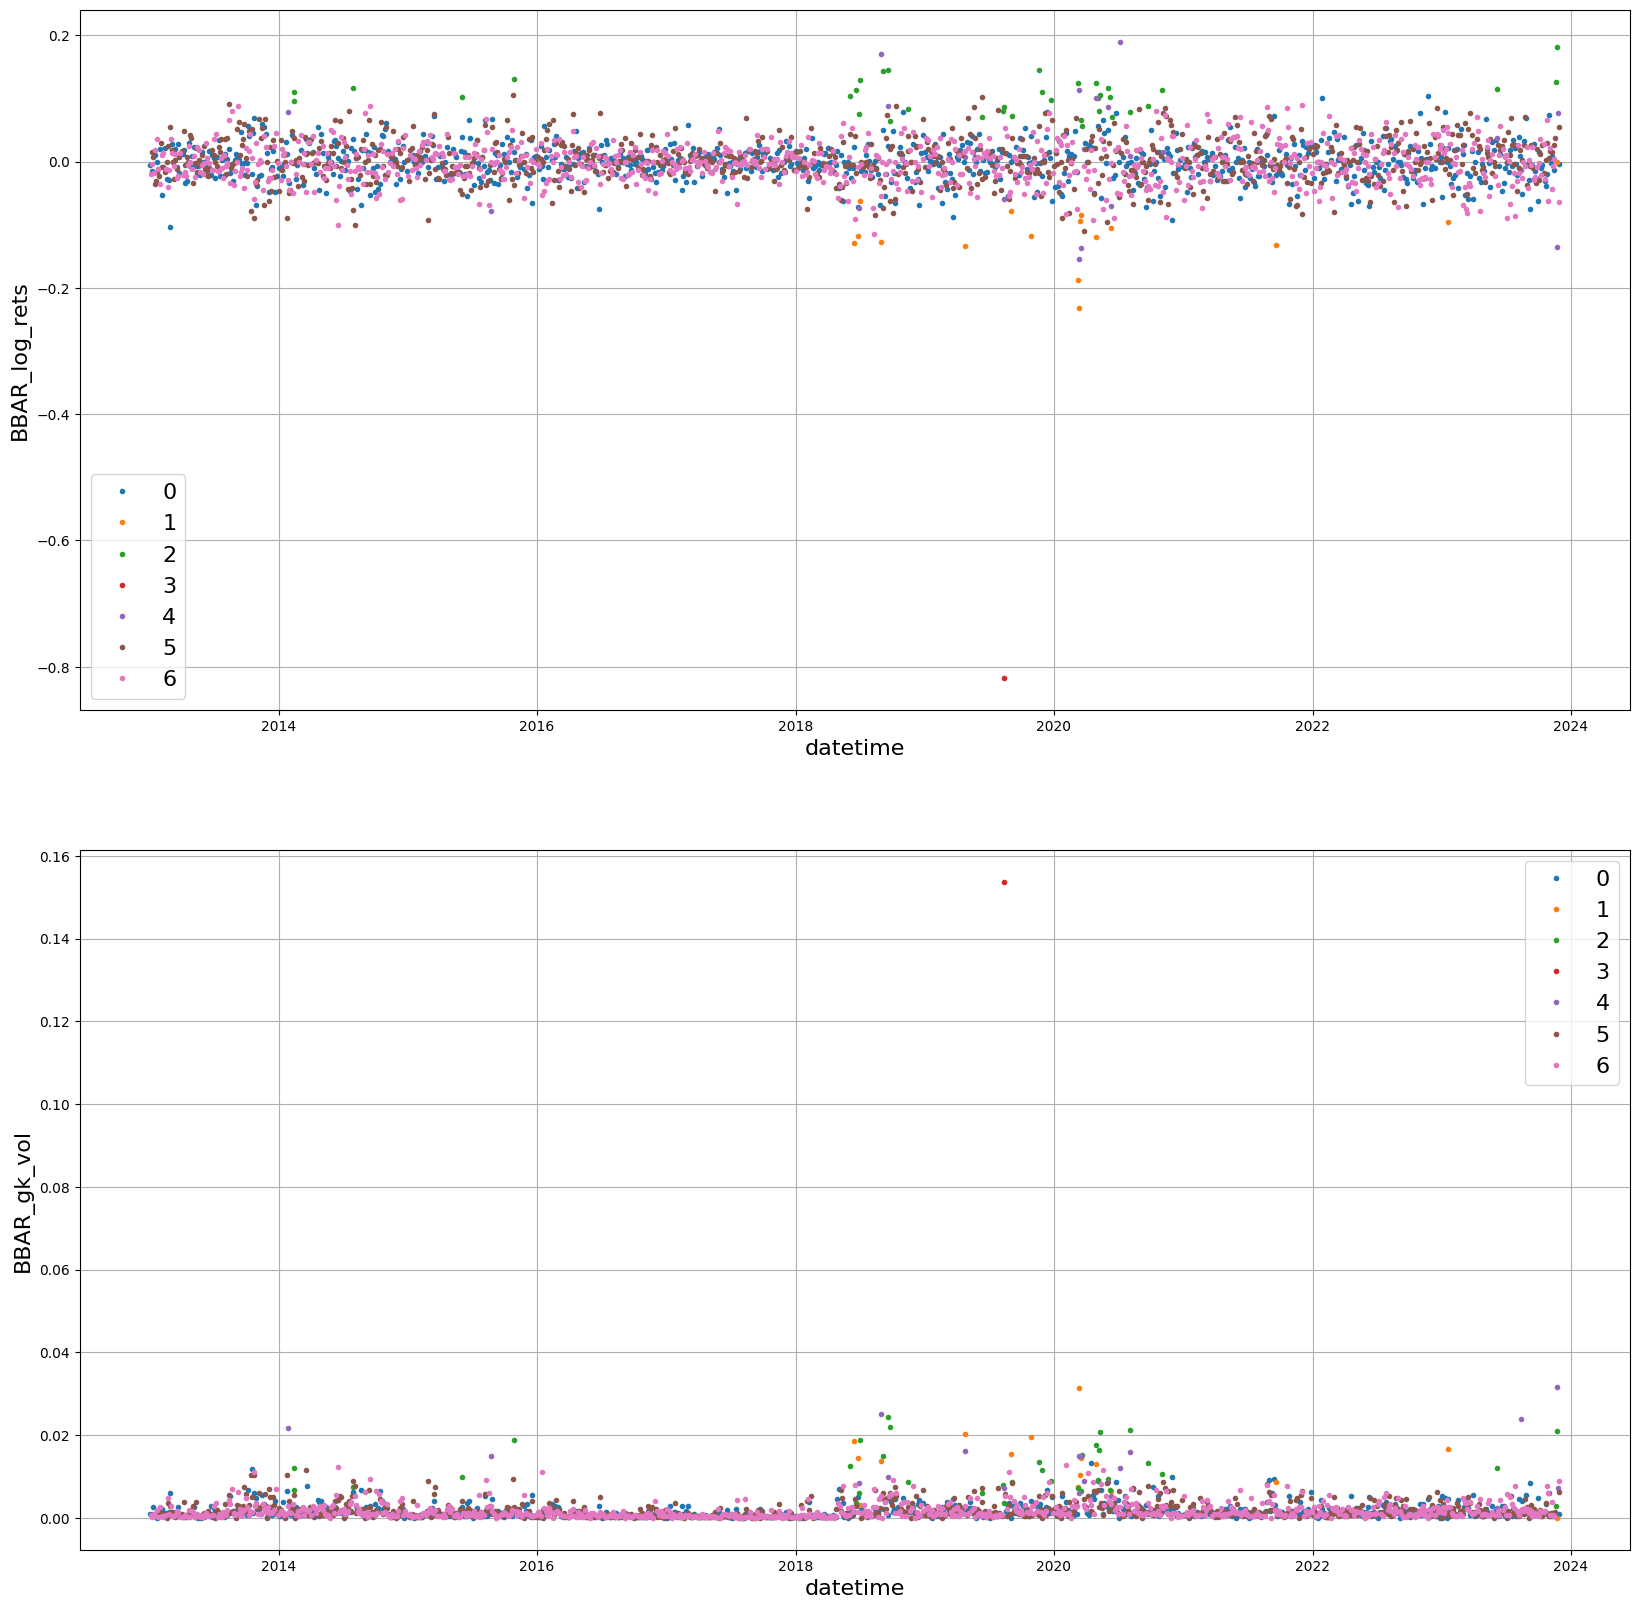

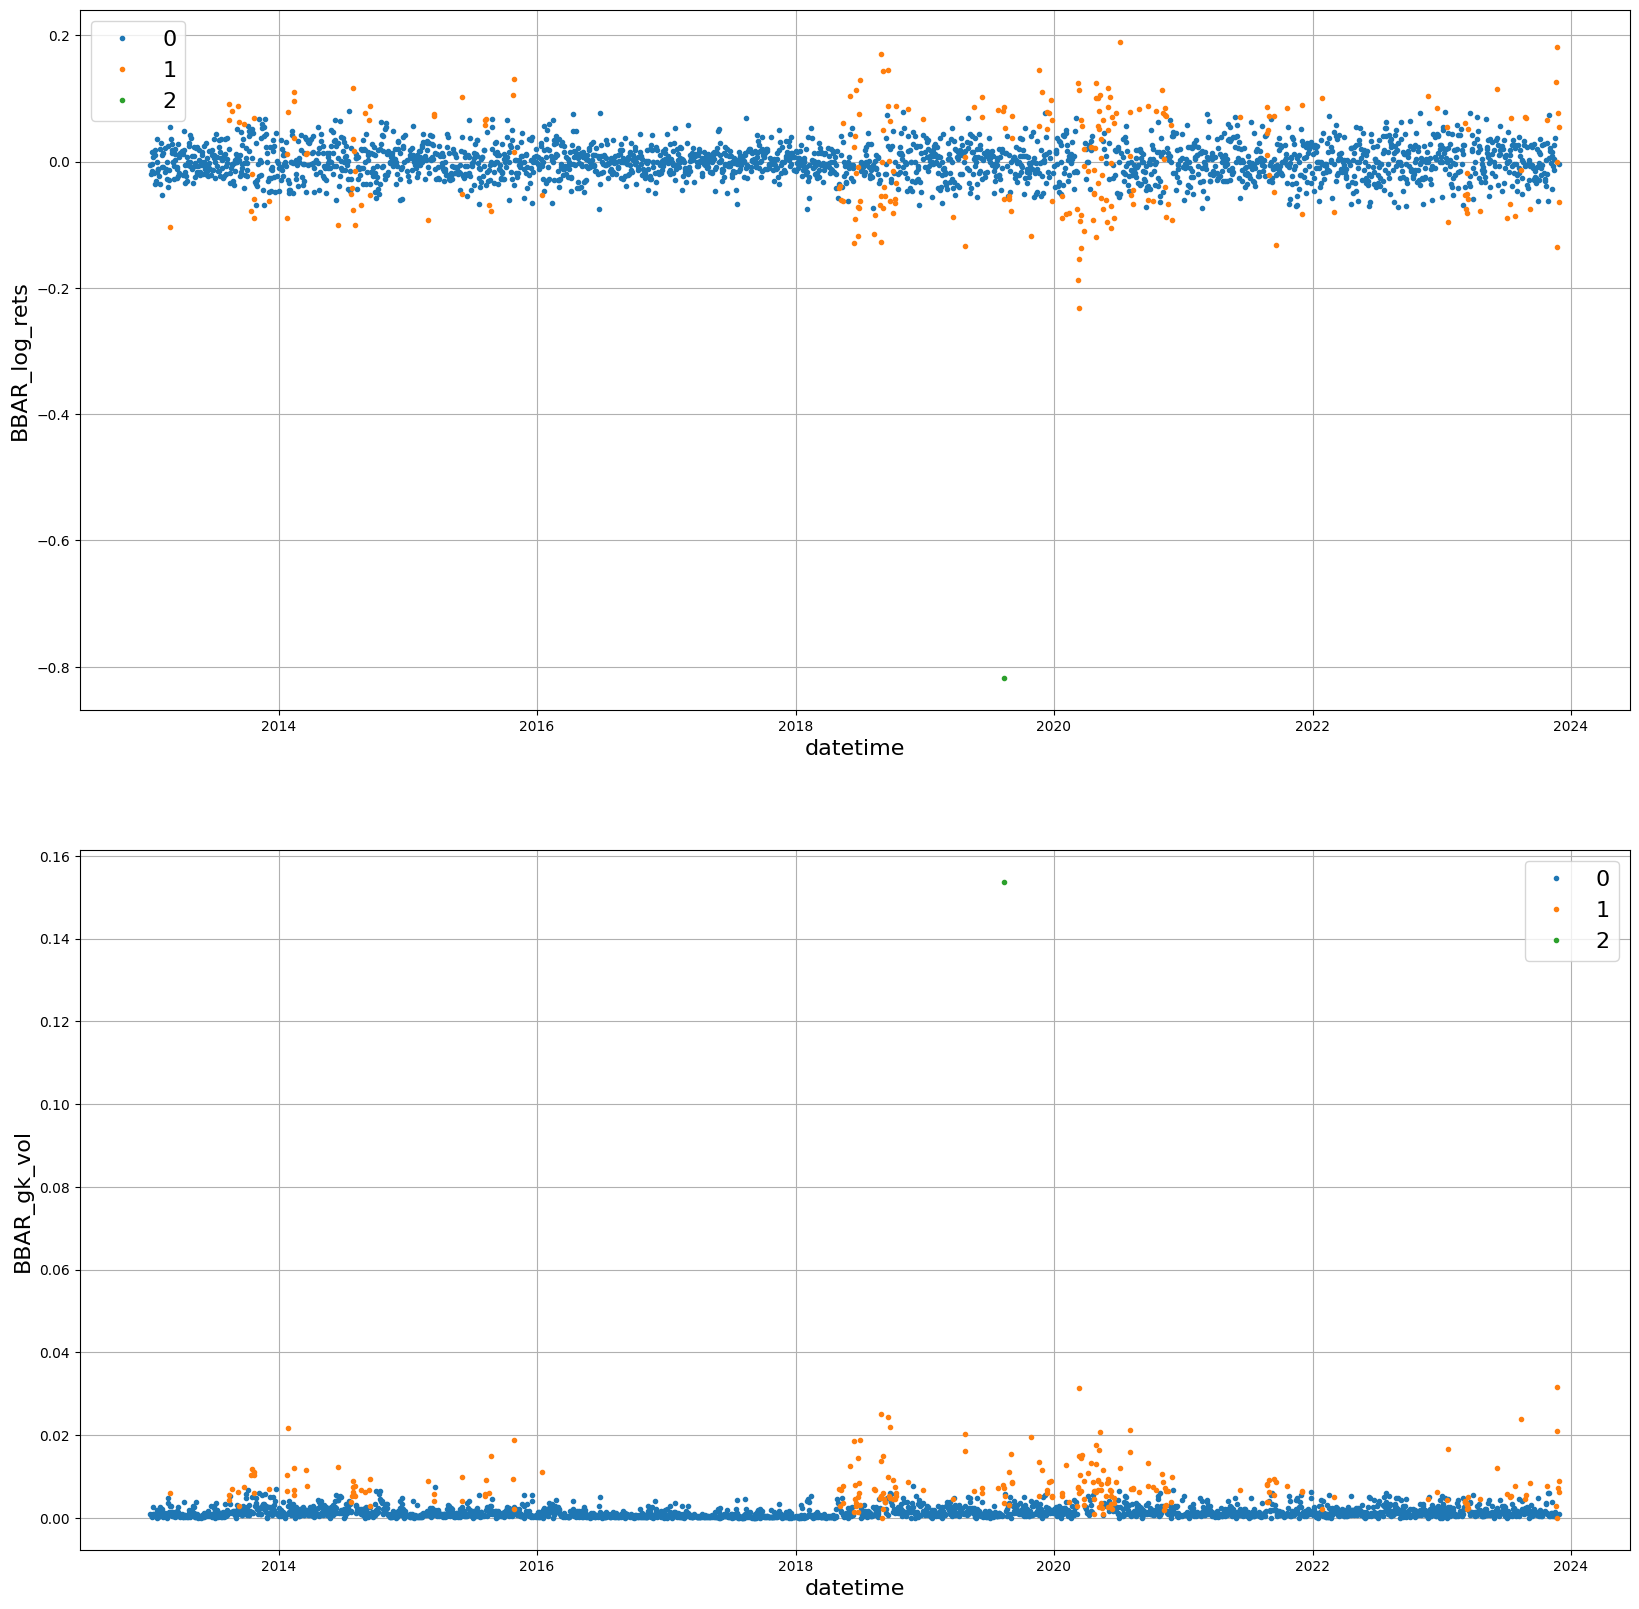

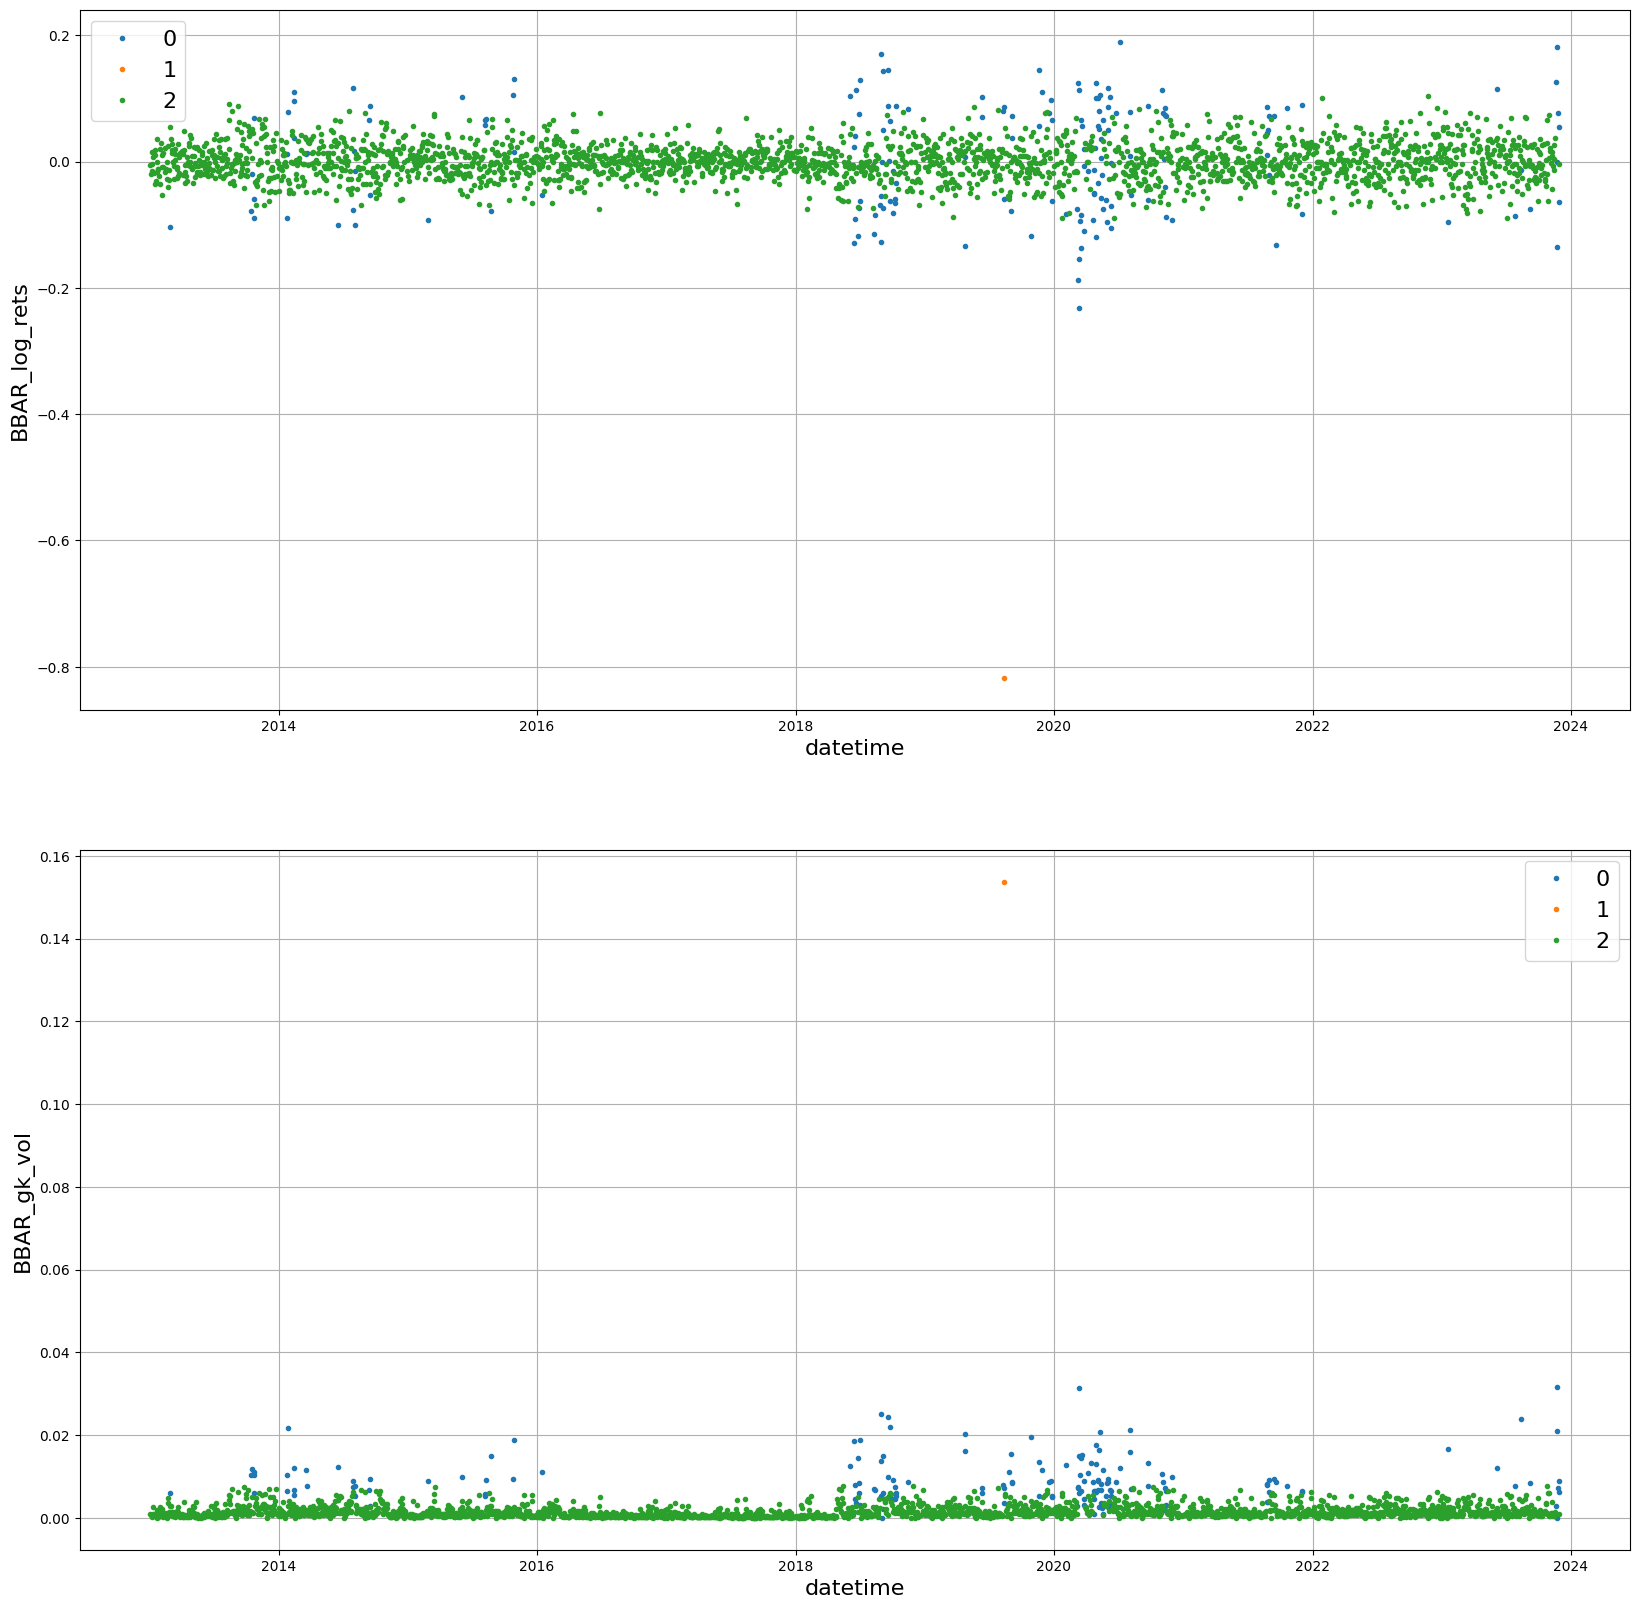

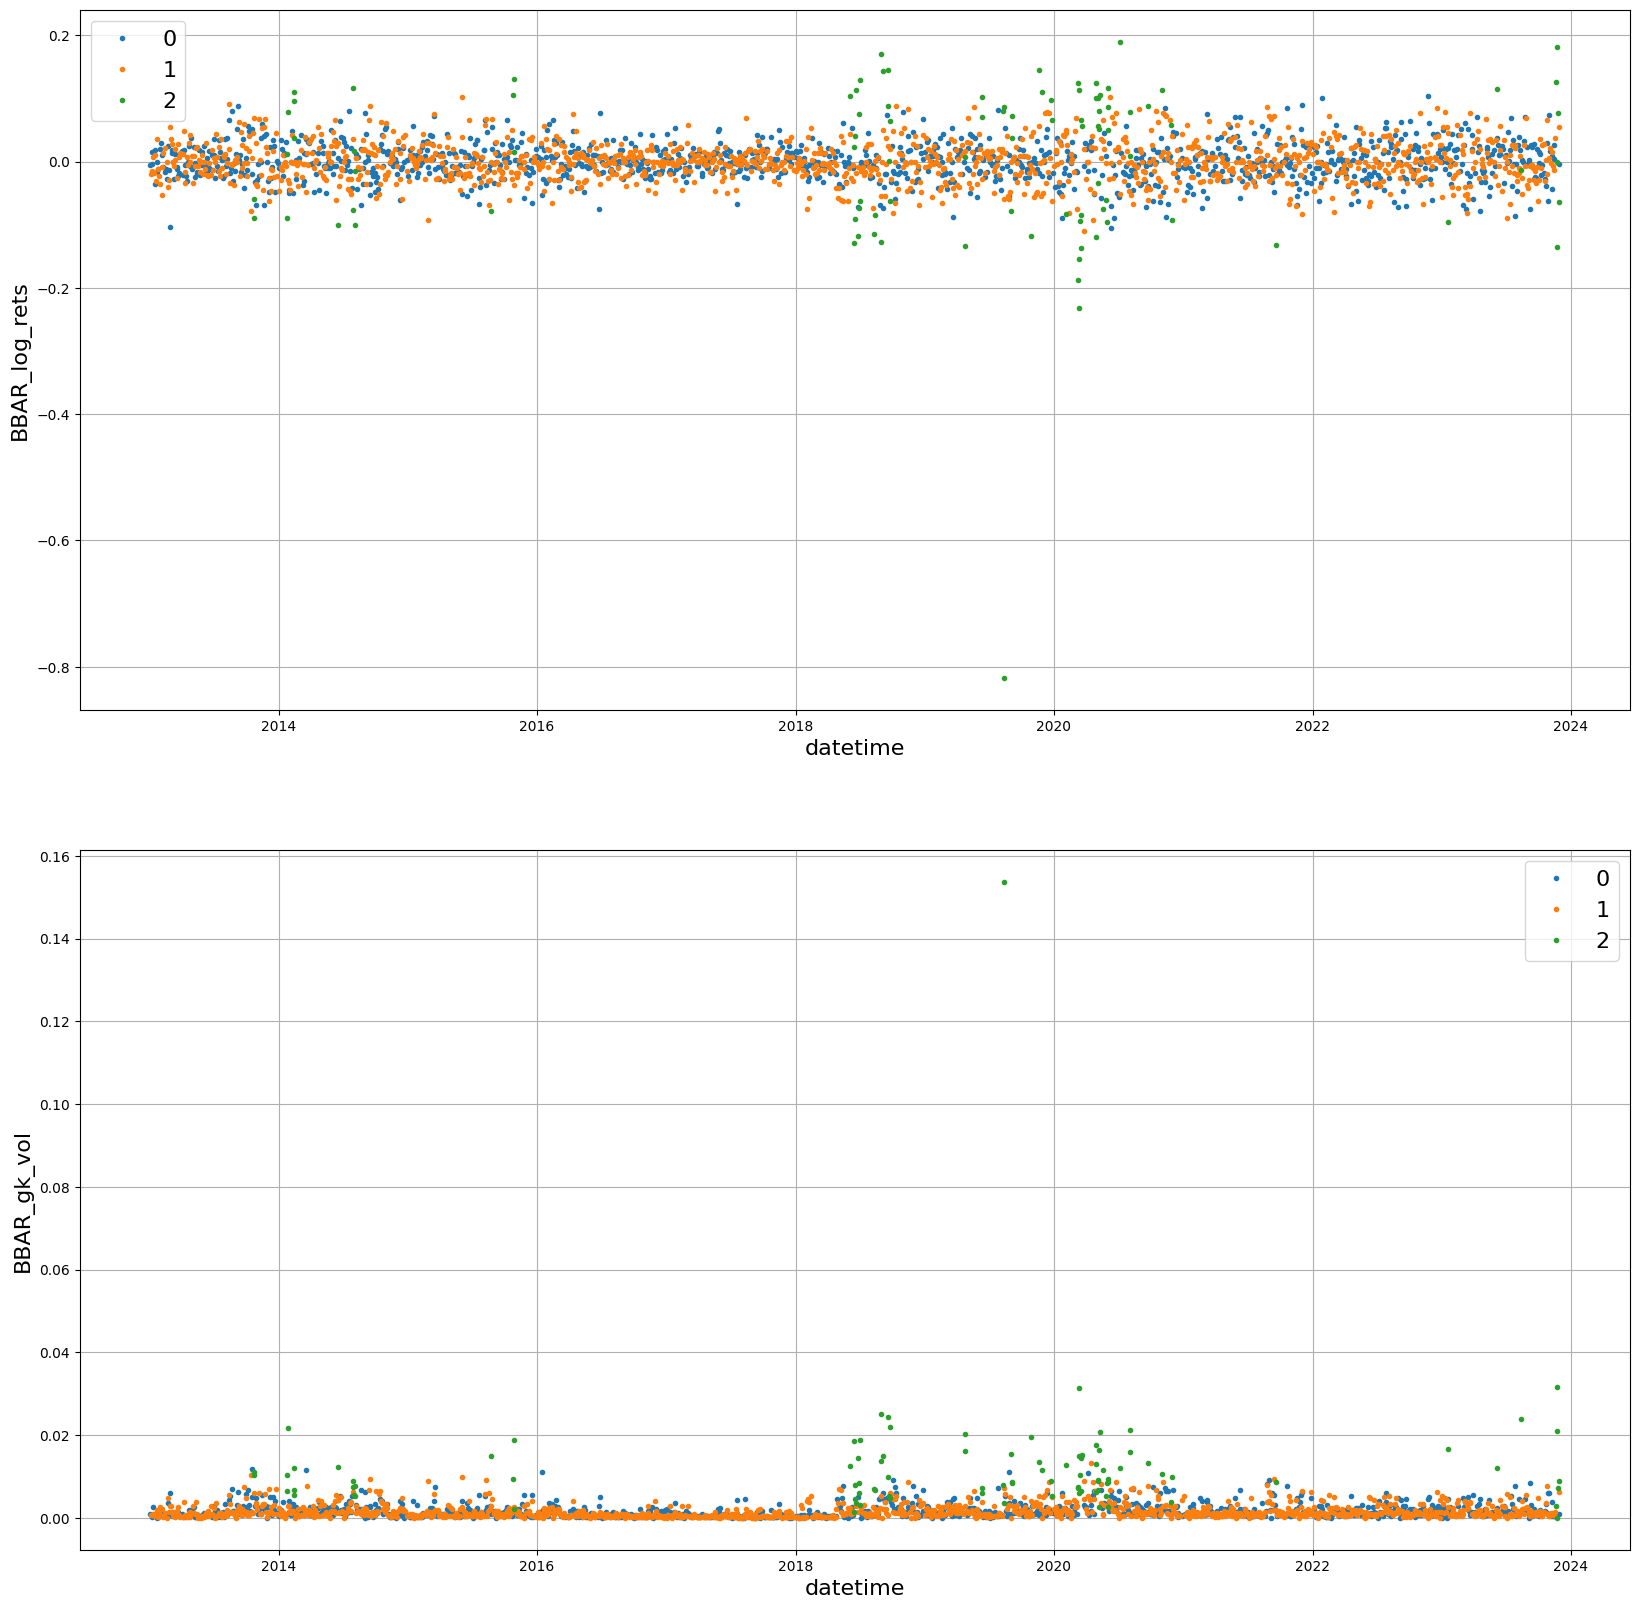

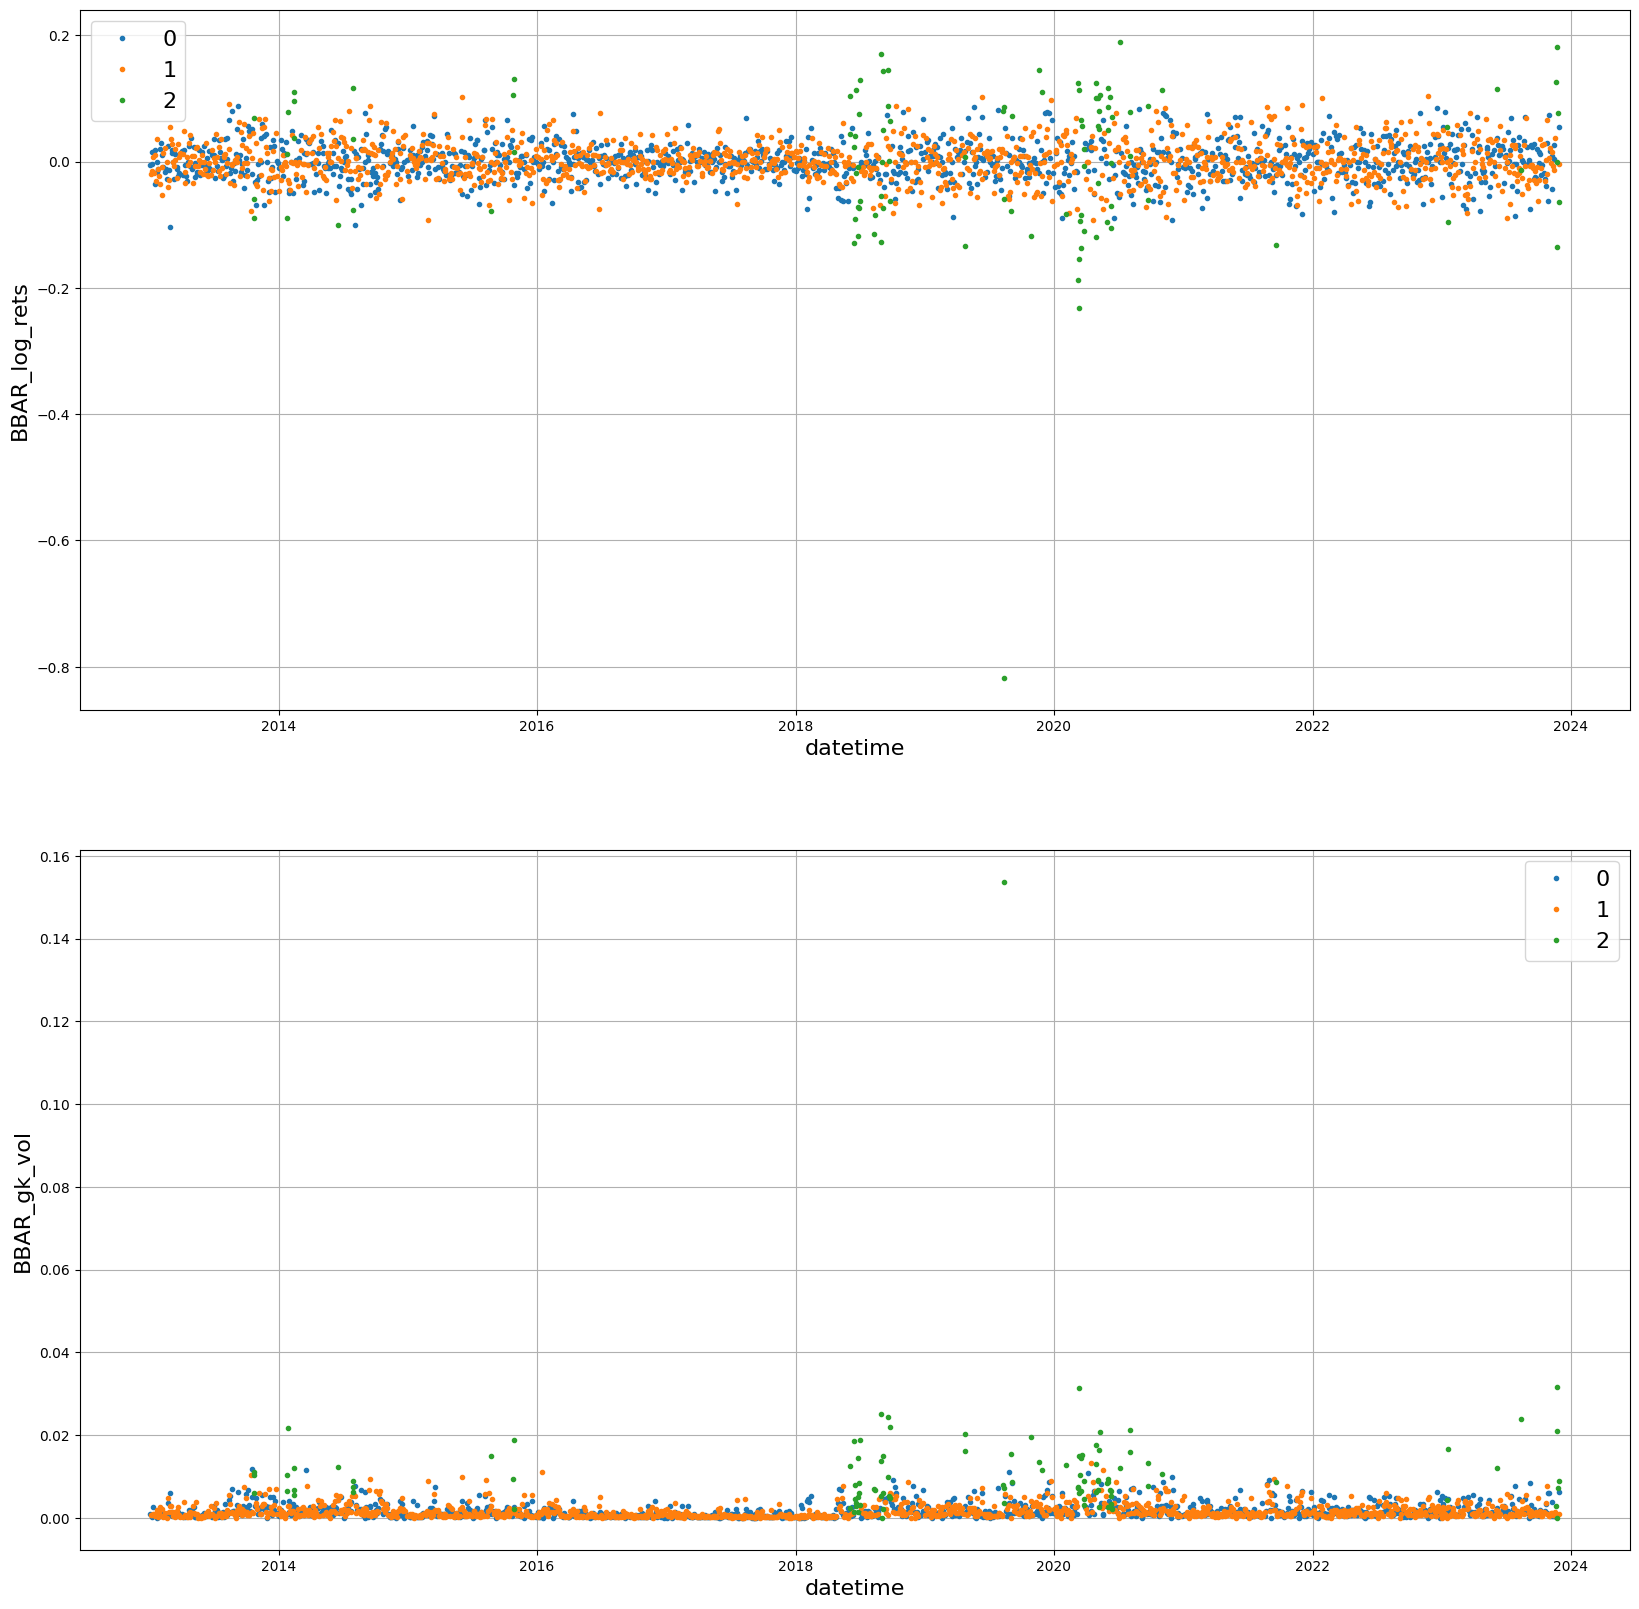

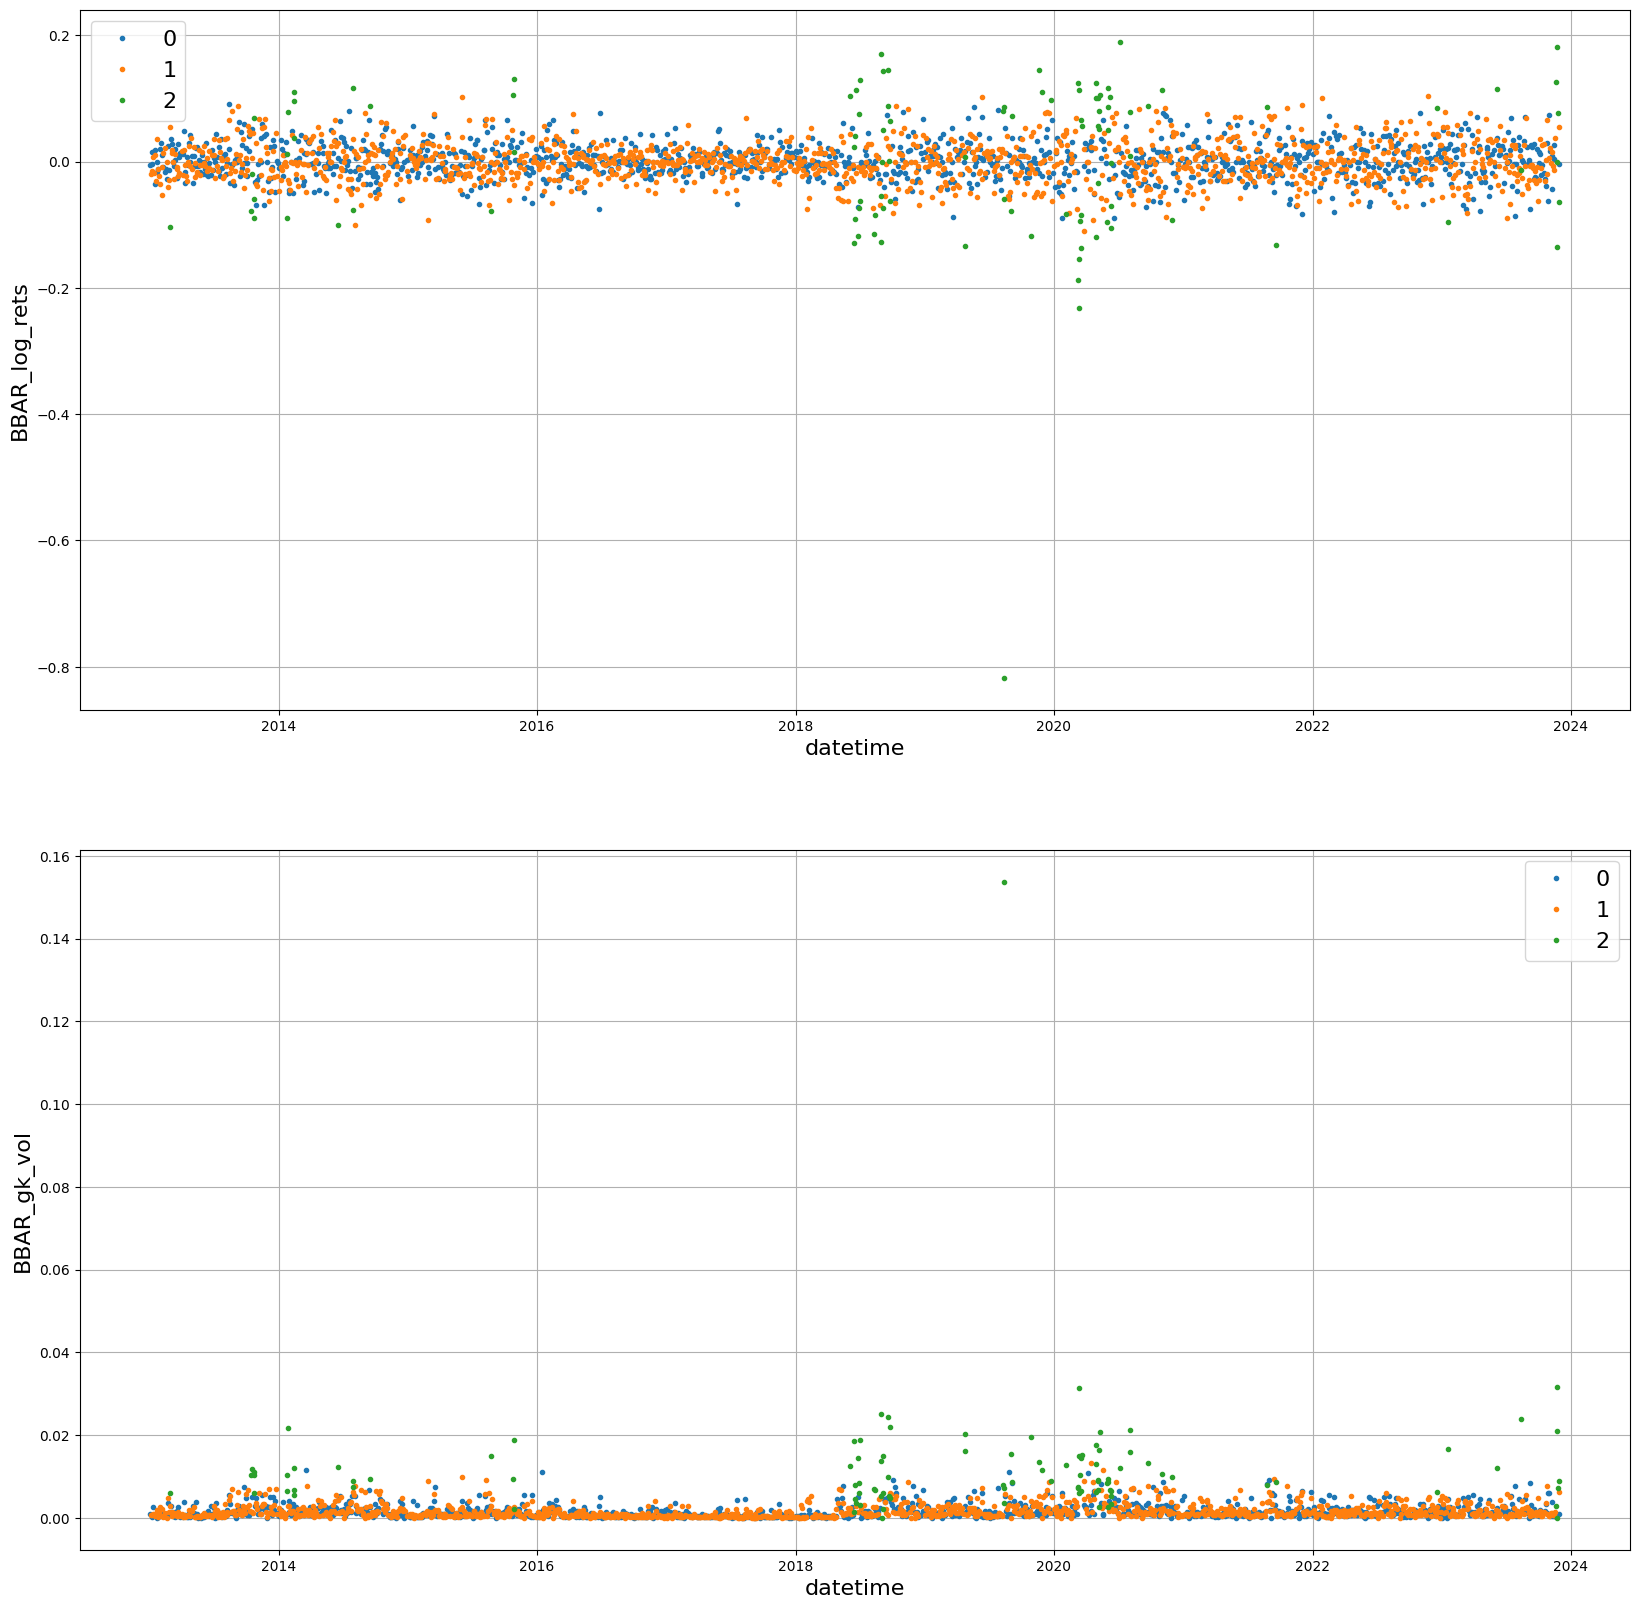

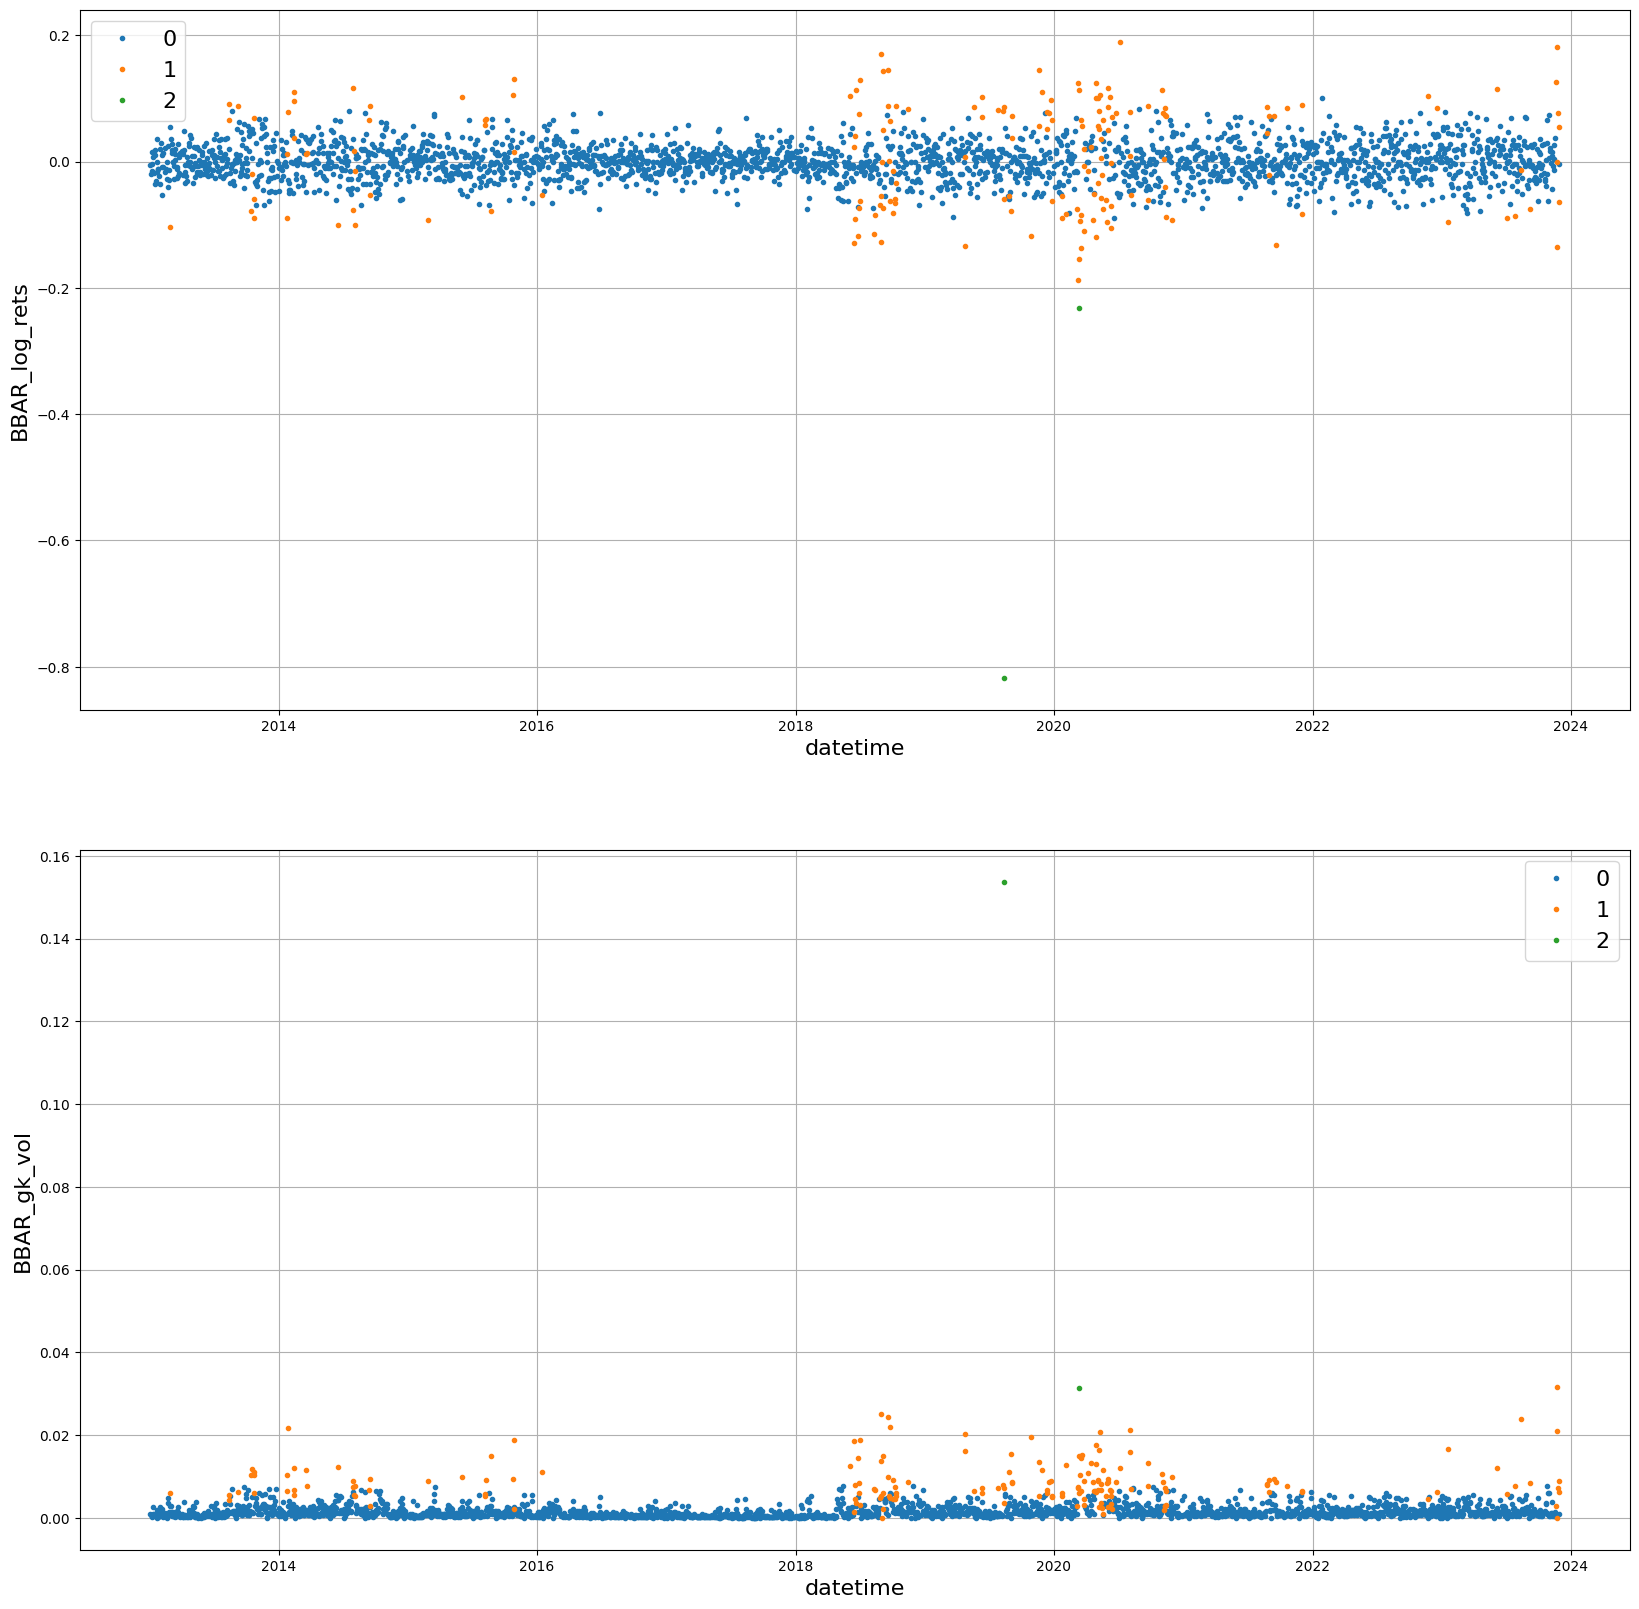

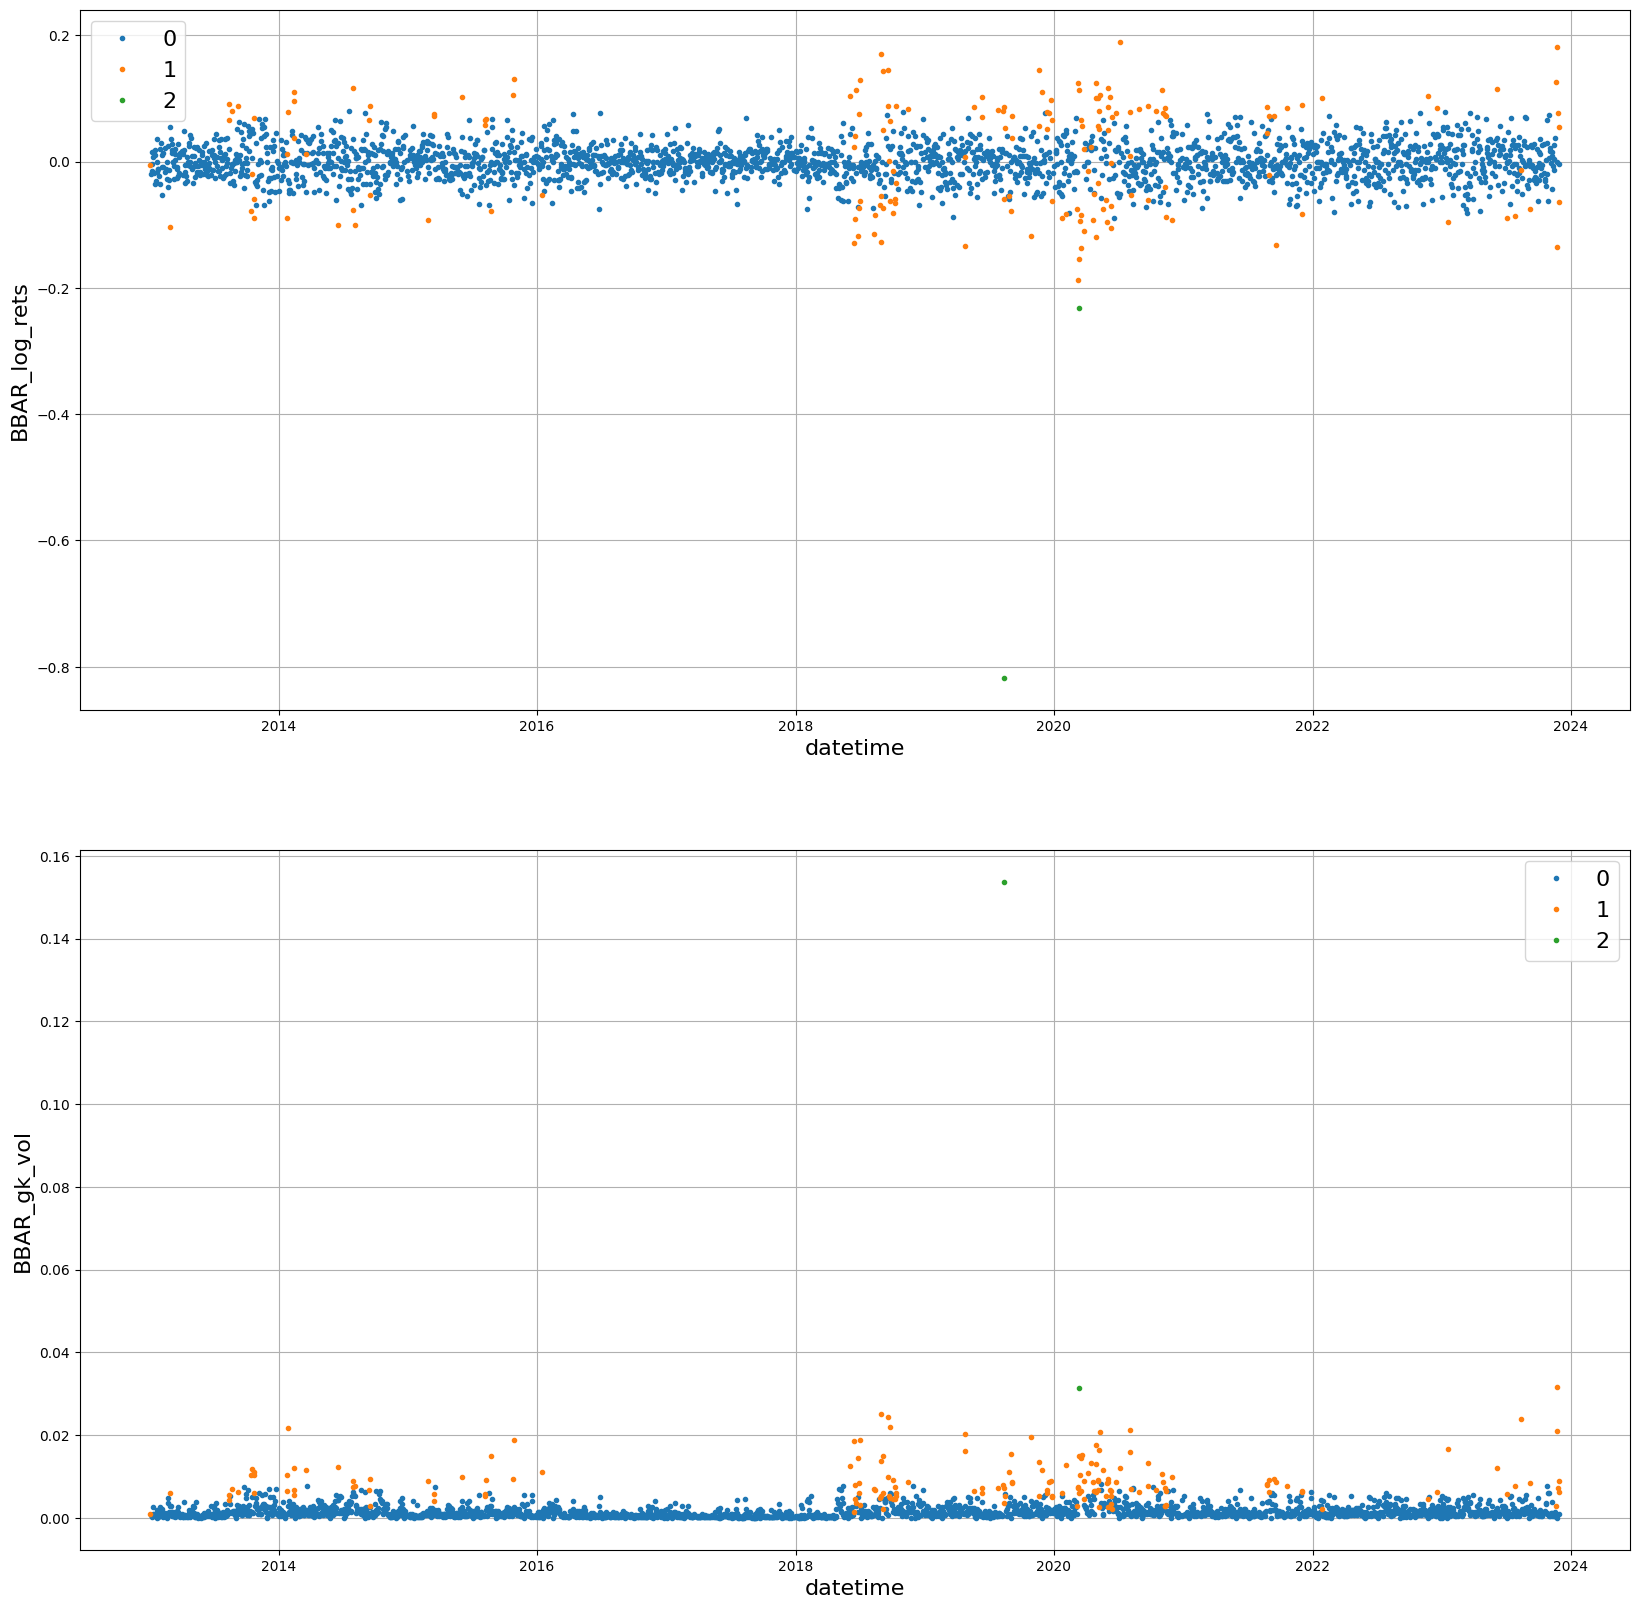

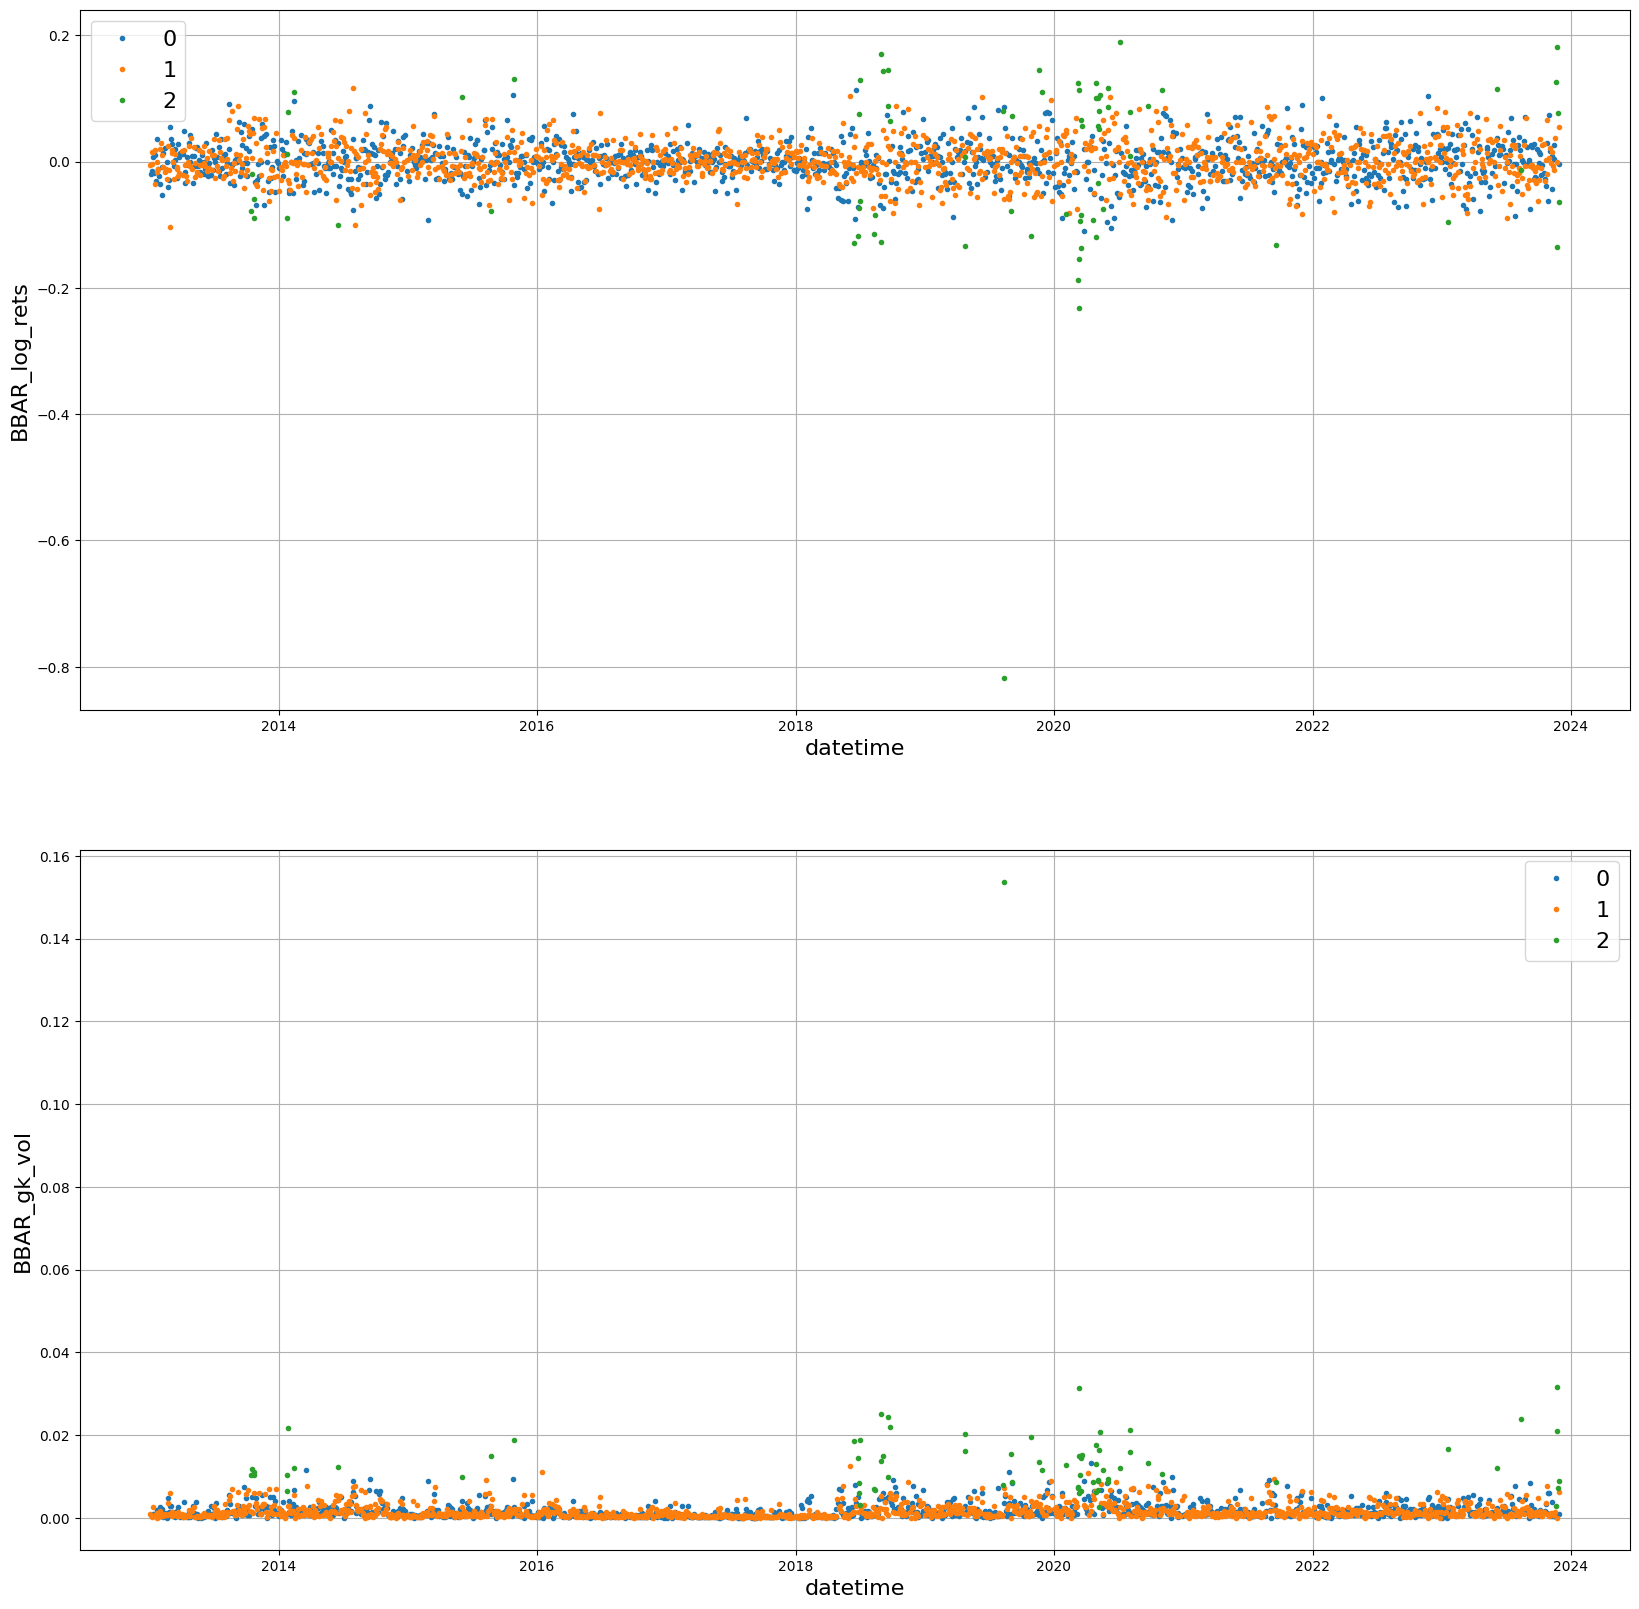

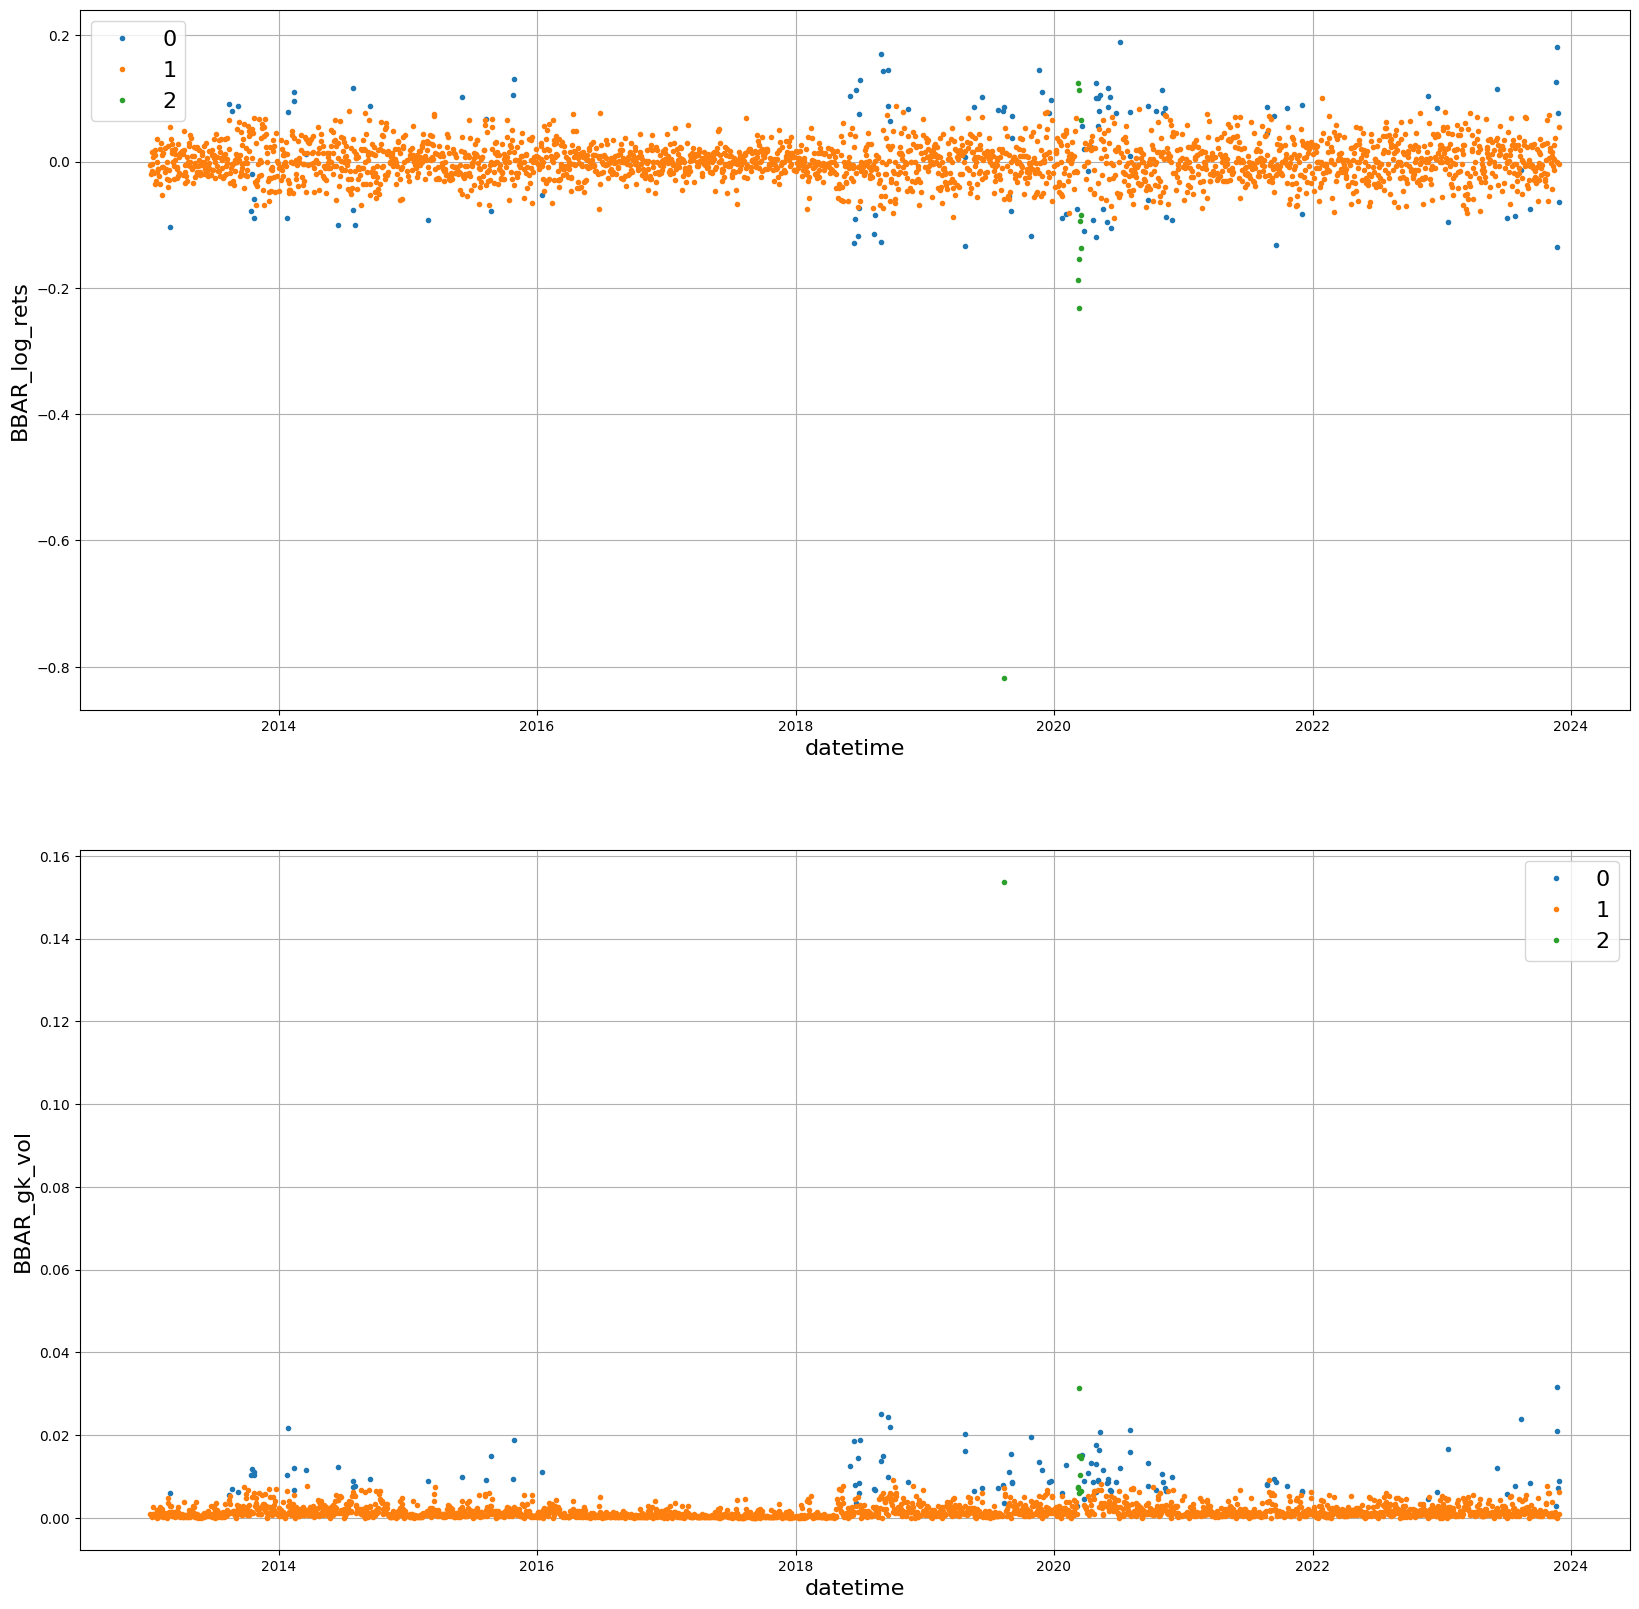

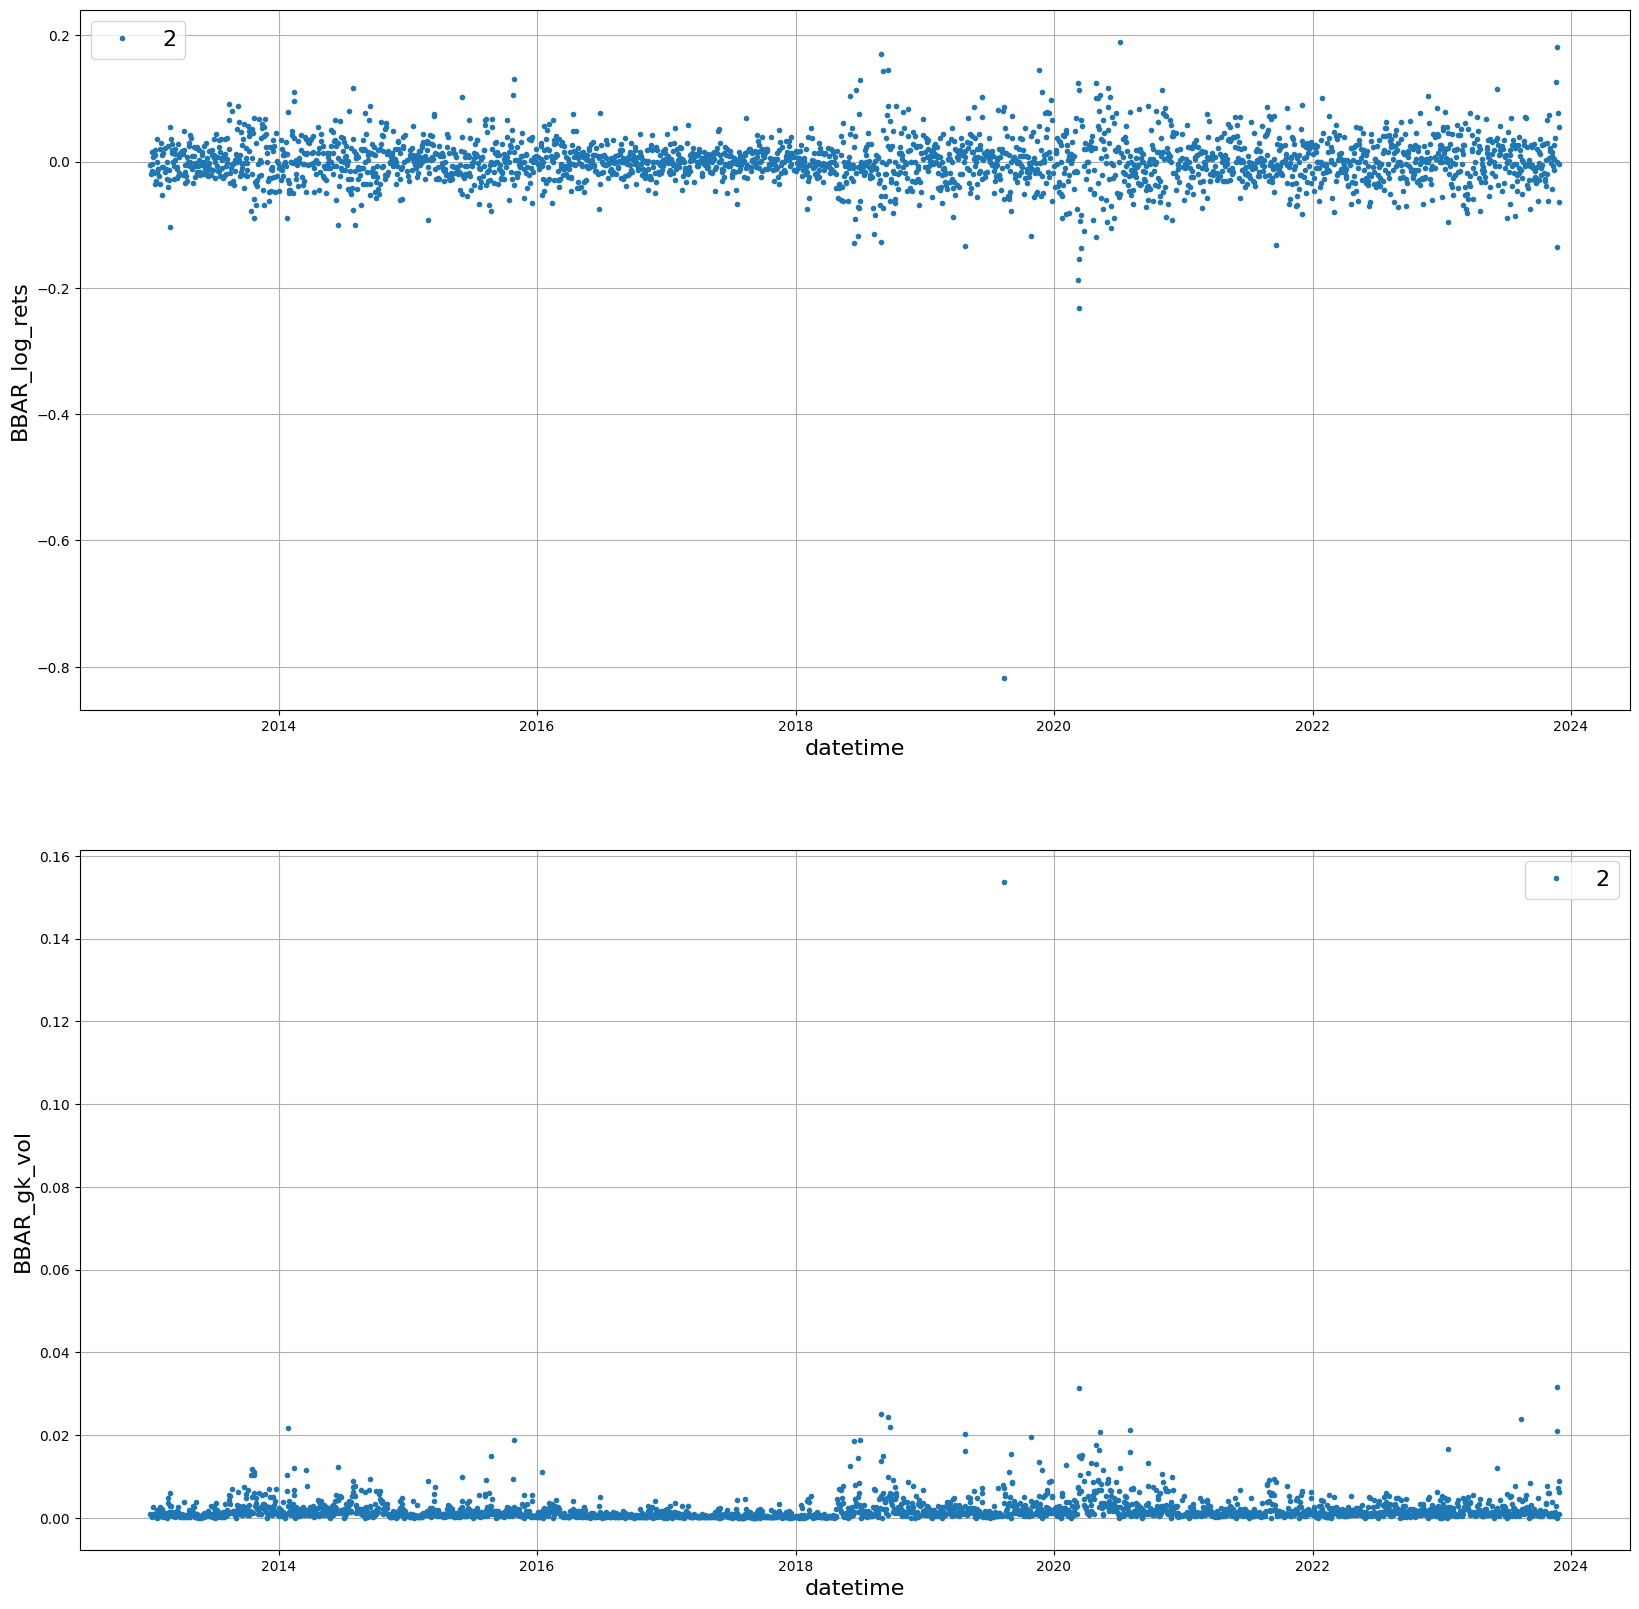

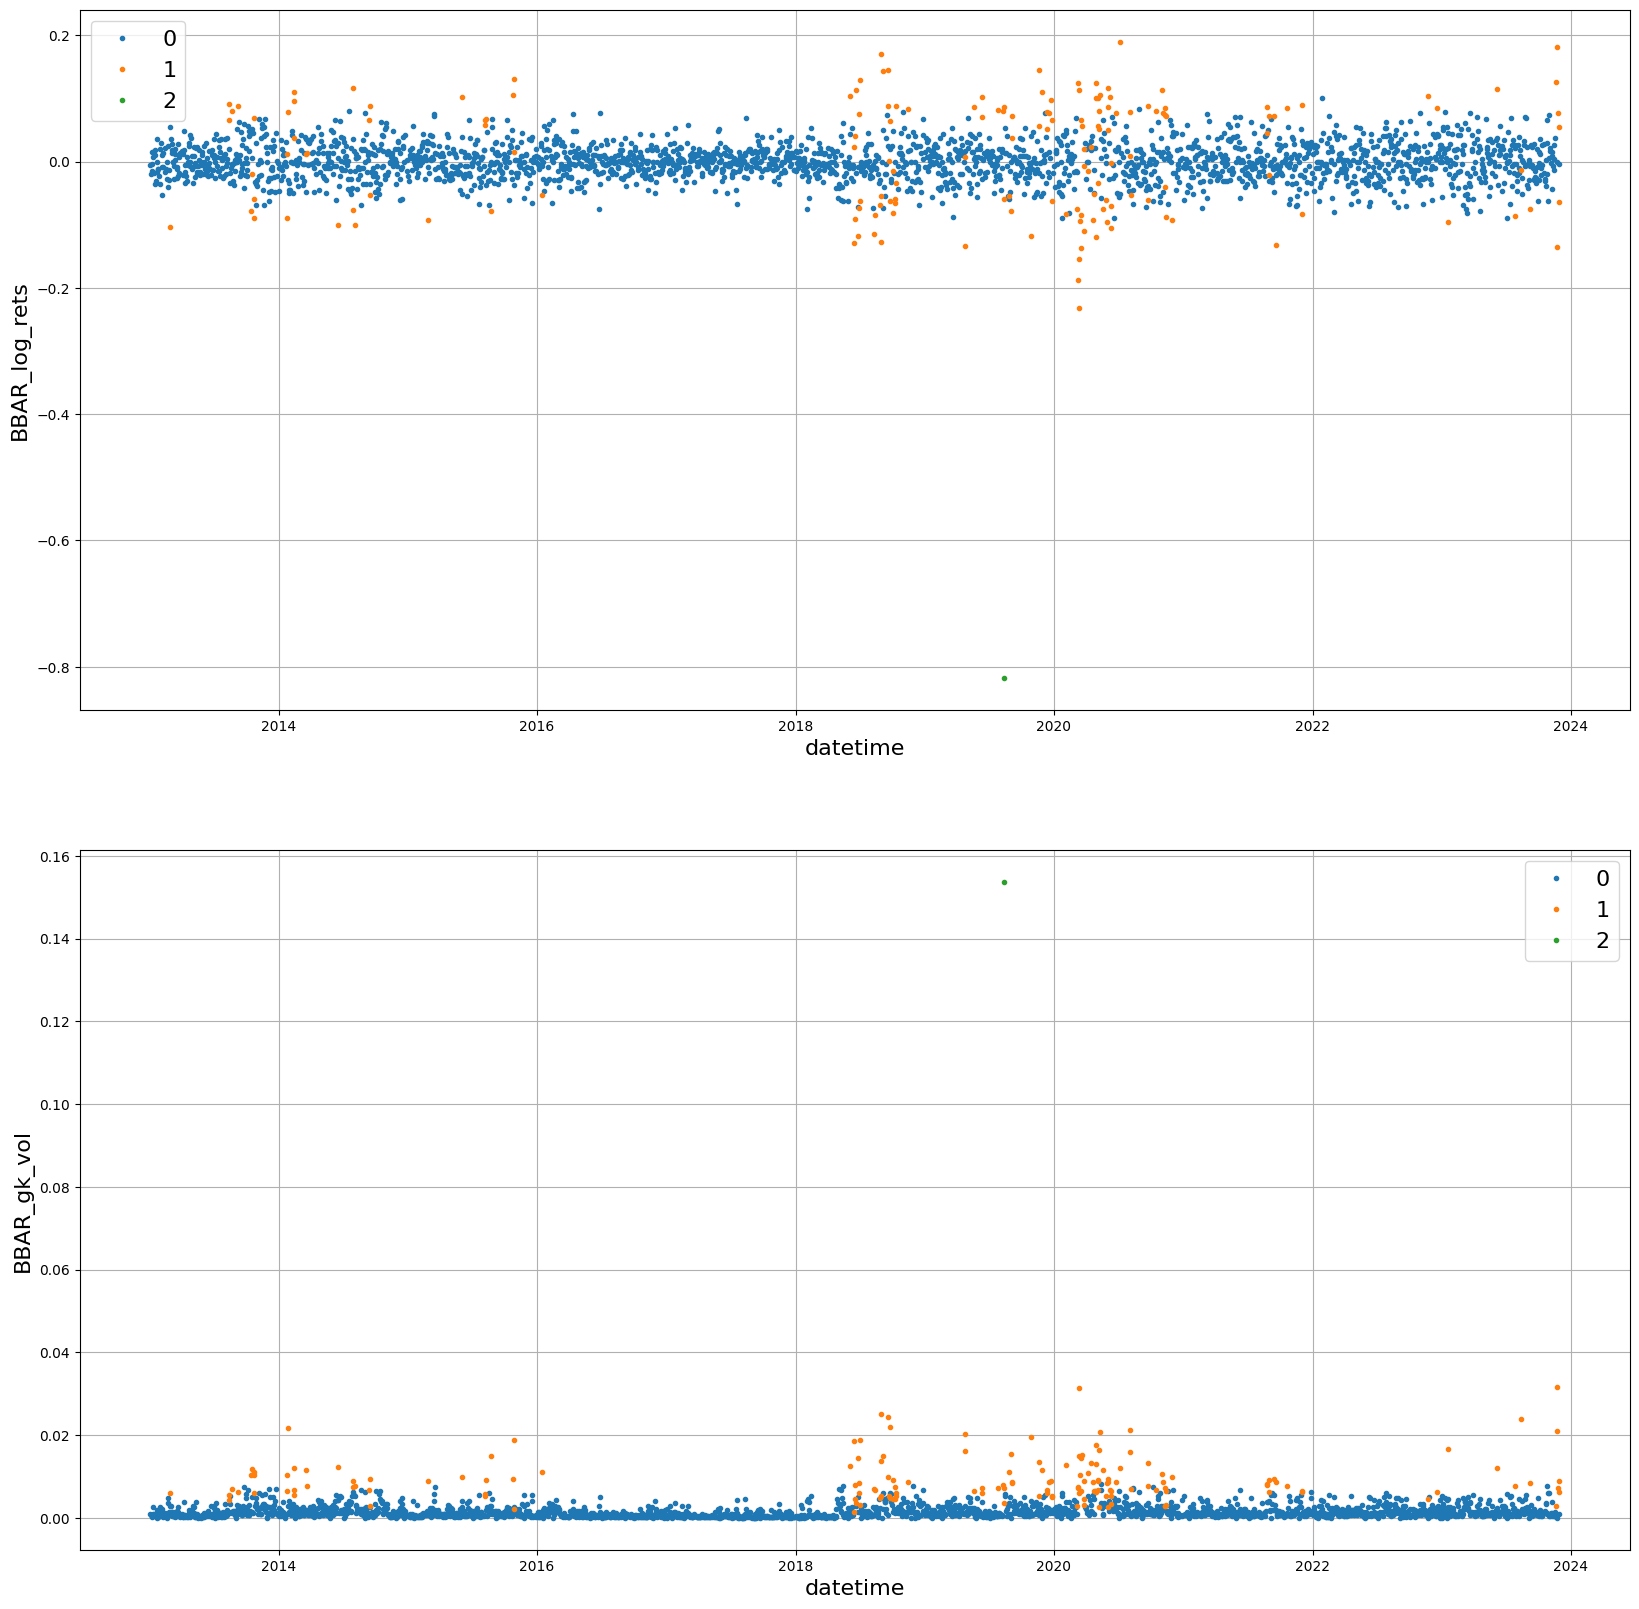

In [73]:
for dictionary, IC in zip([aic_best_model, bic_best_model], ["AIC", "BIC"]):
    for key, model in dictionary.items():
        columns = [f'{stock}_log_rets', f'{stock}_gk_vol']
        insample_data = df[columns]
        oos_data=df_test[columns]
        train_end=insample_data.index.max()
        data=pd.concat([insample_data, oos_data])

        plot_close_rets_vol(model, data, key, IC)

## HMM Selection

Selecting the Number of States in Hidden Markov Models: Pragmatic Solutions Illustrated Using Animal Movement
https://sci-hub.st/10.1007/s13253-017-0283-8